In [1]:
# ÌååÏùº Ïù¥Î¶Ñ: 01_build_ultimate_dataset.py
# Ïó≠Ìï†: Î™®Îì† ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôÄ, Ìå©ÌÑ∞ÏôÄ Îß§ÌÅ¨Î°ú ÏßÄÌëú(Feature)Î•º ÎßåÎì§Í≥†,
#       ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ ÌïôÏäµÏóê ÌïÑÏöîÌïú Ï†ïÎãµ(Label)ÏùÑ ÏÉùÏÑ±ÌïòÏó¨
#       ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ ÎßåÎìúÎäî Ïä§ÌÅ¨Î¶ΩÌä∏.

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò ---
def load_base_data(stock_filepath, macro_filepath):
    """Î™®Îì† ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨Ïò§Í≥† Í∏∞Î≥∏ Ï†ÑÏ≤òÎ¶¨Î•º ÏàòÌñâÌï©ÎãàÎã§."""
    print("ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìúÎ•º ÏãúÏûëÌï©ÎãàÎã§...")
    if not os.path.exists(stock_filepath) or not os.path.exists(macro_filepath):
        raise FileNotFoundError("ÌïÑÏöîÌïú ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏù¥ ÏóÜÏäµÎãàÎã§.")
        
    stock_df = pd.read_csv(stock_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(macro_df['Ïó∞ÎèÑ'].astype(str) + '-' + macro_df['Ïõî'].astype(str), format='%Y-%m')
    print("‚úÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!")
    return stock_df, macro_df

# --- 2. Feature ÏÉùÏÑ± Ìï®ÏàòÎì§ ---
def prepare_all_factors(df):
    print("Î™®Îì† Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§...")
    df = df.copy()

    # ‚úÖ ÏàòÏ†ïÎêú Ìå©ÌÑ∞ Î¶¨Ïä§Ìä∏
    factor_list = [
        'value_score', 'quality_score', 'momentum_score', 'size_score',
        'volatility_score', 'op_margin_score', 'attention_score', 'mean_reversion_score'
    ]

    # Ìå©ÌÑ∞ Í≥ÑÏÇ∞
    df['pbr_score'] = -df['PBR']
    df['per_score'] = -df['PER']
    df['psr_score'] = -df['PSR']
    df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1)

    df['quality_score'] = df['ROE']
    df['momentum_score'] = df['12Í∞úÏõîÏàòÏùµÎ•†']
    df['size_score'] = -df['ÏãúÍ∞ÄÏ¥ùÏï°']

    df = df.sort_values(by=['Ï¢ÖÎ™©ÏΩîÎìú', 'Í∏∞Ï§ÄÏõî'])
    df['volatility'] = df.groupby('Ï¢ÖÎ™©ÏΩîÎìú')['1Í∞úÏõîÏàòÏùµÎ•†'].transform(lambda x: x.rolling(12, 6).std())
    df['volatility_score'] = -df['volatility']
    df['op_margin_score'] = df['ÏòÅÏóÖÏù¥ÏùµÎ•†']
    df['attention_score'] = df['ÌèâÍ∑†Í±∞ÎûòÎüâÏ¶ùÍ∞ÄÏú®'] + df['Í±∞ÎûòÌöåÏ†ÑÏú®']
    df['mean_reversion_score'] = -df['1Í∞úÏõîÏàòÏùµÎ•†']

    for col in factor_list:
        df[col] = df.groupby('Í∏∞Ï§ÄÏõî')[col].transform(
            lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5
        )
    df[factor_list] = df[factor_list].fillna(0.5)
    print("‚úÖ Î™®Îì† Ìå©ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!")
    return df

def create_themed_macro_indices(macro_df):
    print("ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§..."); macro_proc = macro_df.set_index('Í∏∞Ï§ÄÏõî').copy(); macro_cols = ['WTI', 'VIX', 'Ïã§ÏóÖÎ•†', 'CPI', 'Í∏àÎ¶¨', 'ÌôòÏú®']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['Ïã§ÏóÖÎ•†_z_score', 'Í∏àÎ¶¨_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', 'ÌôòÏú®_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("‚úÖ ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ ÏÉùÏÑ± ÏôÑÎ£å!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïö© Ï†ïÎãµ(Label) Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§..."); df = df_original.copy(); df['next_month_return'] = df.groupby('Ï¢ÖÎ™©ÏΩîÎìú')['1Í∞úÏõîÏàòÏùµÎ•†'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å!"); return df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]

if __name__ == '__main__':
    stock_filepath = "stock_0.3ver.csv"; macro_filepath = "Í±∞ÏãúÍ≤ΩÏ†ú ÏõîÎ≥Ñ ÏßÄÌëú ÏµúÏ¢Ö.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_all_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("Î™®Îì† FeatureÏôÄ LabelÏùÑ ÏµúÏ¢Ö Í≤∞Ìï©Ìï©ÎãàÎã§...")
    final_df = pd.merge(df_with_all_factors, macro_features, on='Í∏∞Ï§ÄÏõî', how='left')
    final_df = pd.merge(final_df, labels_df, on=['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú'], how='inner')
    final_df.ffill(inplace=True)

    print("Feature Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞ÌïòÏó¨ ÏµúÏ†ÅÏùò FeatureÎ•º ÏÑ†Î≥ÑÌï©ÎãàÎã§...")
    features_for_selection = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    X = final_df[features_for_selection]; y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(20).index.tolist()
    print(f"‚úÖ ÏÑ†ÌÉùÎêú ÏµúÏÉÅÏúÑ Feature:\n{top_features}")
    
    final_ml_dataset = final_df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", index=False)
    # Î∞±ÌÖåÏä§ÌåÖ Ïãú Ï¢ÖÎ™© Ï°∞ÌöåÎ•º ÏúÑÌï¥ Ï†ÑÏ≤¥ Ìå©ÌÑ∞ Îç∞Ïù¥ÌÑ∞ÎèÑ Ï†ÄÏû•
    df_with_all_factors.to_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/full_feature_stock_data.csv", index=False)
    
    print("\n--- Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§! ---"); print("ÏÉùÏÑ±Îêú ÌååÏùº: ultimate_ml_dataset.csv, full_feature_stock_data.csv")
    print("Ïù¥Ï†ú '02_run_final_comparison.py'Î•º Ïã§ÌñâÌïòÏó¨ Î∞±ÌÖåÏä§Ìä∏Î•º ÏßÑÌñâÌïòÏÑ∏Ïöî.")


ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìúÎ•º ÏãúÏûëÌï©ÎãàÎã§...
‚úÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!
Î™®Îì† Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§...
‚úÖ Î™®Îì† Ìå©ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!
ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
‚úÖ ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ ÏÉùÏÑ± ÏôÑÎ£å!
ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïö© Ï†ïÎãµ(Label) Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å!
Î™®Îì† FeatureÏôÄ LabelÏùÑ ÏµúÏ¢Ö Í≤∞Ìï©Ìï©ÎãàÎã§...
Feature Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞ÌïòÏó¨ ÏµúÏ†ÅÏùò FeatureÎ•º ÏÑ†Î≥ÑÌï©ÎãàÎã§...
‚úÖ ÏÑ†ÌÉùÎêú ÏµúÏÉÅÏúÑ Feature:
['value_score', 'mean_reversion_score', 'quality_score', 'momentum_score', 'size_score', 'op_margin_score', 'attention_score', 'pbr_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§! ---
ÏÉùÏÑ±Îêú ÌååÏùº: ultimate_ml_dataset.csv, full_feature_stock_data.csv
Ïù¥Ï†ú '02_run_final_comparison.py'Î•º Ïã§ÌñâÌïòÏó¨ Î∞±ÌÖåÏä§Ìä∏Î•º ÏßÑÌñâÌïòÏÑ∏Ïöî.


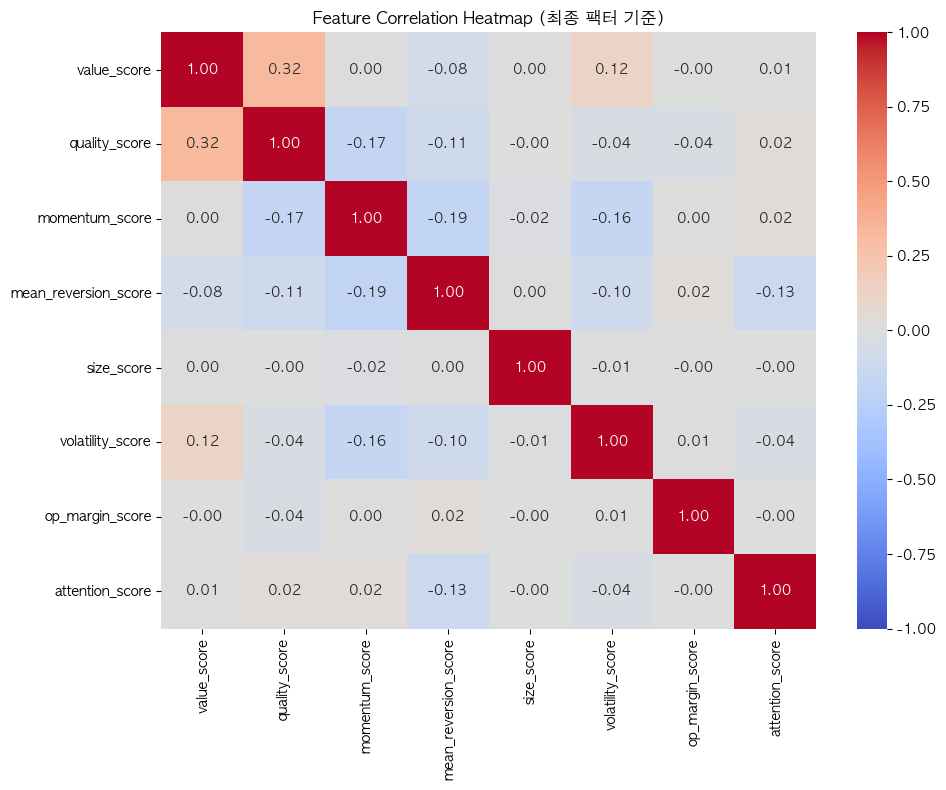

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    plt.rc('font', family='AppleGothic')
except Exception as e:
    print(f"Ìè∞Ìä∏ ÏÑ§Ï†ï Ïò§Î•ò: {e}. Í∏∞Î≥∏ Ìè∞Ìä∏Î°ú ÏÑ§Ï†ïÎê©ÎãàÎã§.")
plt.rcParams['axes.unicode_minus'] = False


# --- Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞ ---
df = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/full_feature_stock_data.csv")

# ‚úÖ ÏµúÏ¢Ö ÏÑ†Ï†ïÎêú Ìå©ÌÑ∞ Î™©Î°ù
factor_cols = [
    'value_score',
    'quality_score',
    'momentum_score',
    'mean_reversion_score',
    'size_score',
    'volatility_score',
    'op_margin_score',
    'attention_score'
]

# --- ÌîºÏ≥ê Í∞Ñ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Í≥ÑÏÇ∞ ---
corr = df[factor_cols].corr()

# --- ÏãúÍ∞ÅÌôî ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap (ÏµúÏ¢Ö Ìå©ÌÑ∞ Í∏∞Ï§Ä)")
plt.tight_layout()
plt.show()

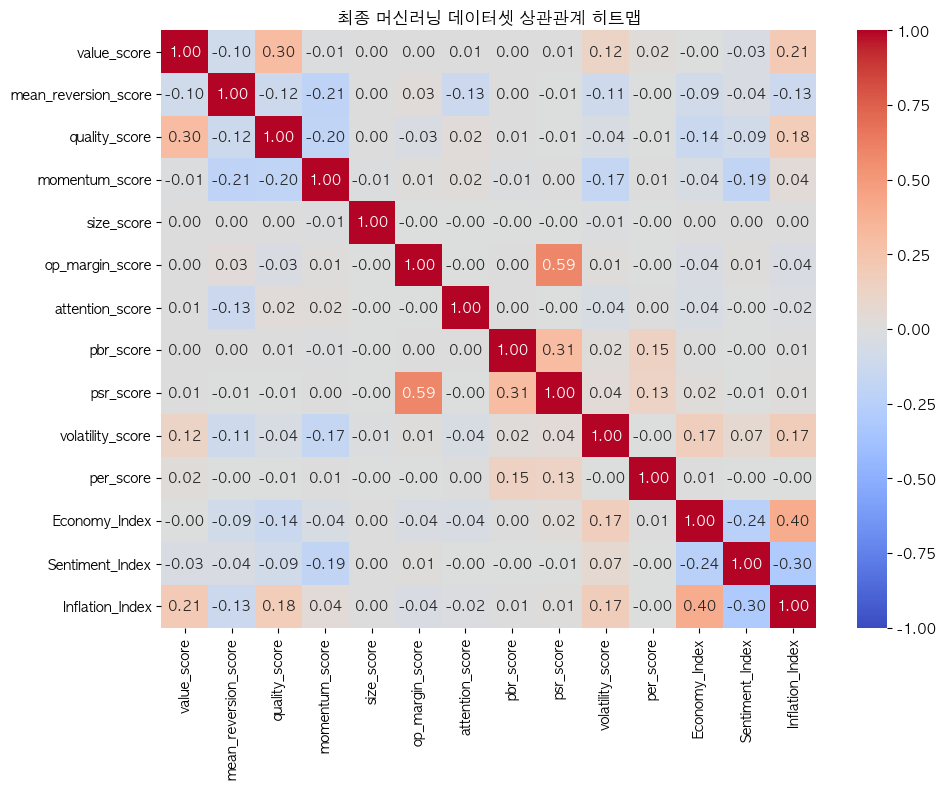

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Îç∞Ïù¥ÌÑ∞ Î°úÎî© ---
df = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv")

# --- ÌîºÏ≥ê Ïª¨Îüº ÏûêÎèô Ï∂îÏ∂ú (yÍ∞í Ï†úÏô∏) ---
feature_cols = [col for col in df.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]

# --- ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑù ---
corr = df[feature_cols].corr()

# --- ÏãúÍ∞ÅÌôî ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ")
plt.tight_layout()
plt.show()

In [4]:
# ÌååÏùº Ïù¥Î¶Ñ: 01_build_ultimate_dataset.py (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ Í∏∞Îä• Ï∂îÍ∞Ä)

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò ---
def load_base_data(stock_filepath, macro_filepath):
    print("ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìúÎ•º ÏãúÏûëÌï©ÎãàÎã§...")
    stock_df = pd.read_csv(stock_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(macro_df['Ïó∞ÎèÑ'].astype(str) + '-' + macro_df['Ïõî'].astype(str), format='%Y-%m')
    print("‚úÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!")
    return stock_df, macro_df

# --- 2. Feature ÏÉùÏÑ± Ìï®ÏàòÎì§ ---
def prepare_all_factors(df):
    """Î≥¥Ïú†Ìïú Î™®Îì† Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©ÌïòÏó¨ Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§."""
    print("Î™®Îì† Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§...")
    df = df.copy()
    factor_list = ['value_score', 'quality_score', 'momentum_score', 'size_score', 'volatility_score', 'op_margin_score', 'debt_ratio_score', 'robust_momentum_score', 'attention_score']
    df['pbr_score'] = -df['PBR']; df['per_score'] = -df['PER']; df['psr_score'] = -df['PSR']; df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1)
    df['quality_score'] = df['ROE']; df['momentum_score'] = df['12Í∞úÏõîÏàòÏùµÎ•†']; df['size_score'] = -df['ÏãúÍ∞ÄÏ¥ùÏï°']
    df = df.sort_values(by=['Ï¢ÖÎ™©ÏΩîÎìú', 'Í∏∞Ï§ÄÏõî']); df['volatility'] = df.groupby('Ï¢ÖÎ™©ÏΩîÎìú')['1Í∞úÏõîÏàòÏùµÎ•†'].transform(lambda x: x.rolling(12, 6).std()); df['volatility_score'] = -df['volatility']; df['op_margin_score'] = df['ÏòÅÏóÖÏù¥ÏùµÎ•†']; df['debt_ratio_score'] = -df['Î∂ÄÏ±ÑÎπÑÏú®']
    df['robust_momentum_score'] = df['momentum_accel'] + df['trend_positive_count'] + df['momentum_trend_slope']; df['attention_score'] = df['ÌèâÍ∑†Í±∞ÎûòÎüâÏ¶ùÍ∞ÄÏú®'] + df['Í±∞ÎûòÌöåÏ†ÑÏú®']
    for col in factor_list:
        df[col] = df.groupby('Í∏∞Ï§ÄÏõî')[col].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5)
    df[factor_list] = df[factor_list].fillna(0.5); print("‚úÖ Î™®Îì† Ìå©ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!"); return df

def create_themed_macro_indices(macro_df):
    print("ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§..."); macro_proc = macro_df.set_index('Í∏∞Ï§ÄÏõî').copy(); macro_cols = ['WTI', 'VIX', 'Ïã§ÏóÖÎ•†', 'CPI', 'Í∏àÎ¶¨', 'ÌôòÏú®']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['Ïã§ÏóÖÎ•†_z_score', 'Í∏àÎ¶¨_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', 'ÌôòÏú®_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("‚úÖ ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ ÏÉùÏÑ± ÏôÑÎ£å!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïö© Ï†ïÎãµ(Label) Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§..."); df = df_original.copy(); df['next_month_return'] = df.groupby('Ï¢ÖÎ™©ÏΩîÎìú')['1Í∞úÏõîÏàòÏùµÎ•†'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å!"); return df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]

def remove_highly_correlated_features(df, threshold=0.8):
    """ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÌîºÏ≥ê Ï§ë ÌïòÎÇòÎ•º Ï†úÍ±∞ÌïòÏó¨ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï©ÎãàÎã§."""
    print(f"ÏÉÅÍ¥ÄÍ≥ÑÏàò ÏûÑÍ≥ÑÍ∞í {threshold} Ï¥àÍ≥º ÌîºÏ≥êÎ•º Ï†úÍ±∞Ìï©ÎãàÎã§...")
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    if not to_drop:
        print("‚úÖ Ï†úÍ±∞Ìï† ÌîºÏ≥êÍ∞Ä ÏóÜÏäµÎãàÎã§.")
    else:
        print(f"‚úÖ Ï†úÍ±∞Îêú ÌîºÏ≥ê: {to_drop}")
        
    return df.drop(to_drop, axis=1)

if __name__ == '__main__':
    stock_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv"; macro_filepath = "Í±∞ÏãúÍ≤ΩÏ†ú ÏõîÎ≥Ñ ÏßÄÌëú ÏµúÏ¢Ö.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("Î™®Îì† FeatureÏôÄ LabelÏùÑ ÏµúÏ¢Ö Í≤∞Ìï©Ìï©ÎãàÎã§...")
    final_df = pd.merge(df_with_factors, macro_features, on='Í∏∞Ï§ÄÏõî', how='left')
    final_df = pd.merge(final_df, labels_df, on=['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú'], how='inner')
    final_df.ffill(inplace=True)

    # Î®∏Ïã†Îü¨Îãù Î™®Îç∏Ïóê ÏÇ¨Ïö©Ìï† ÏµúÏ¢Ö ÌîºÏ≥êÏÖã Ï†ïÏùò
    features_to_use = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    feature_df = final_df[features_to_use]
    
    # --- Ïó¨Í∏∞Í∞Ä Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ ---
    # 1. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÎÜíÏùÄ ÌîºÏ≥ê Ï†úÍ±∞
    feature_df_decorrelated = remove_highly_correlated_features(feature_df, threshold=0.8)
    
    # 2. Ï†úÍ±∞ ÌõÑ ÎÇ®ÏùÄ ÌîºÏ≥êÎì§Î°ú Feature Importance Ïû¨Í≥ÑÏÇ∞
    print("ÏµúÏ¢Ö ÌîºÏ≥êÏÖãÏúºÎ°ú Feature Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§...")
    X = feature_df_decorrelated
    y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(15).index.tolist() # ÏÉÅÏúÑ 15Í∞ú FeatureÎßå ÏÑ†ÌÉù
    print(f"‚úÖ ÏÑ†ÌÉùÎêú ÏµúÏÉÅÏúÑ Feature (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ ÌõÑ):\n{top_features}")
    
    # 3. ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÄÏû•
    final_ml_dataset = final_df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", index=False)
    
    print("\n--- Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§! ---"); 
    print("ÏÉùÏÑ±Îêú ÌååÏùº: ultimate_ml_dataset.csv")
    print("Ïù¥Ï†ú '02_run_final_comparison.py'Î•º Ïã§ÌñâÌïòÏó¨ Î∞±ÌÖåÏä§Ìä∏Î•º ÏßÑÌñâÌïòÏÑ∏Ïöî.")


ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìúÎ•º ÏãúÏûëÌï©ÎãàÎã§...
‚úÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!
Î™®Îì† Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§...
‚úÖ Î™®Îì† Ìå©ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!
ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
‚úÖ ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ ÏÉùÏÑ± ÏôÑÎ£å!
ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïö© Ï†ïÎãµ(Label) Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å!
Î™®Îì† FeatureÏôÄ LabelÏùÑ ÏµúÏ¢Ö Í≤∞Ìï©Ìï©ÎãàÎã§...
ÏÉÅÍ¥ÄÍ≥ÑÏàò ÏûÑÍ≥ÑÍ∞í 0.8 Ï¥àÍ≥º ÌîºÏ≥êÎ•º Ï†úÍ±∞Ìï©ÎãàÎã§...
‚úÖ Ï†úÍ±∞Îêú ÌîºÏ≥ê: ['debt_ratio_score']
ÏµúÏ¢Ö ÌîºÏ≥êÏÖãÏúºÎ°ú Feature Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§...
‚úÖ ÏÑ†ÌÉùÎêú ÏµúÏÉÅÏúÑ Feature (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ ÌõÑ):
['value_score', 'quality_score', 'robust_momentum_score', 'momentum_score', 'size_score', 'attention_score', 'op_margin_score', 'pbr_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§! ---
ÏÉùÏÑ±Îêú ÌååÏùº: ultimate_ml_dataset.

ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìúÎ•º ÏãúÏûëÌï©ÎãàÎã§...
‚úÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!
Î™®Îì† Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§...
‚úÖ Î™®Îì† Ìå©ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!
ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
‚úÖ ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ ÏÉùÏÑ± ÏôÑÎ£å!
ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïö© Ï†ïÎãµ(Label) Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§...
‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å!
Î™®Îì† FeatureÏôÄ LabelÏùÑ ÏµúÏ¢Ö Í≤∞Ìï©Ìï©ÎãàÎã§...
ÏÉÅÍ¥ÄÍ≥ÑÏàò ÏûÑÍ≥ÑÍ∞í 0.8 Ï¥àÍ≥º ÌîºÏ≥êÎ•º Ï†úÍ±∞Ìï©ÎãàÎã§...
‚úÖ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏïÑ Ï†úÍ±∞Îêú ÌîºÏ≥ê: ['debt_ratio_score']
ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä Ï†úÏñ¥Îêú ÏµúÏ¢Ö ÌîºÏ≥êÏÖãÏùò ÌûàÌä∏ÎßµÏùÑ ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§...


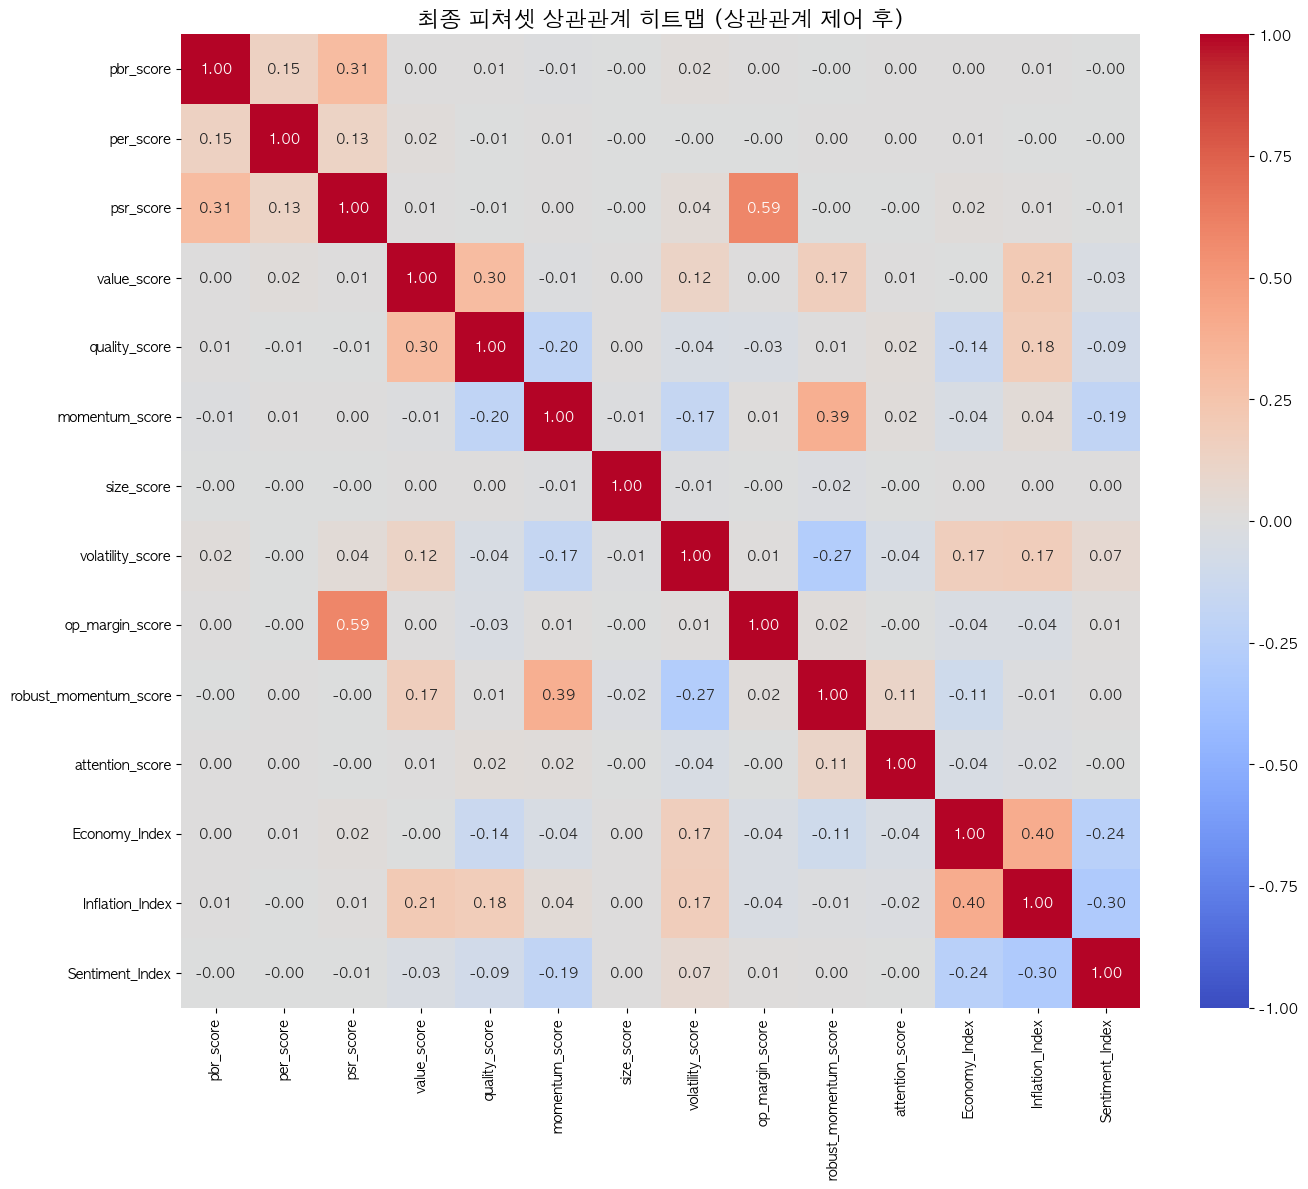

ÏµúÏ¢Ö ÌîºÏ≥êÏÖãÏúºÎ°ú Feature Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§...
‚úÖ ÏÑ†ÌÉùÎêú ÏµúÏÉÅÏúÑ Feature (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ ÌõÑ):
['value_score', 'quality_score', 'robust_momentum_score', 'momentum_score', 'size_score', 'attention_score', 'op_margin_score', 'pbr_score', 'psr_score', 'volatility_score', 'per_score', 'Economy_Index', 'Sentiment_Index', 'Inflation_Index']

--- Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§! ---
ÏÉùÏÑ±Îêú ÌååÏùº: ultimate_ml_dataset.csv
Ïù¥Ï†ú '02_run_final_comparison.py'Î•º Ïã§ÌñâÌïòÏó¨ Î∞±ÌÖåÏä§Ìä∏Î•º ÏßÑÌñâÌïòÏÑ∏Ïöî.


In [5]:
# ÌååÏùº Ïù¥Î¶Ñ: 01_build_ultimate_dataset.py (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ Î∞è ÏãúÍ∞ÅÌôî Í∏∞Îä• Ï∂îÍ∞Ä)

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

# --- Matplotlib ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Í∏∞Î≥∏ Ìè∞Ìä∏Î°ú ÏÑ§Ï†ïÎê©ÎãàÎã§.")
plt.rcParams['axes.unicode_minus'] = False


# --- 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú Ìï®Ïàò ---
def load_base_data(stock_filepath, macro_filepath):
    print("ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìúÎ•º ÏãúÏûëÌï©ÎãàÎã§...")
    stock_df = pd.read_csv(stock_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
    try:
        macro_df = pd.read_csv(macro_filepath, encoding='cp949')
    except UnicodeDecodeError:
        macro_df = pd.read_csv(macro_filepath, encoding='utf-8')
    macro_df['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(macro_df['Ïó∞ÎèÑ'].astype(str) + '-' + macro_df['Ïõî'].astype(str), format='%Y-%m')
    print("‚úÖ ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å!")
    return stock_df, macro_df

# --- 2. Feature ÏÉùÏÑ± Ìï®ÏàòÎì§ ---
def prepare_all_factors(df):
    """Î≥¥Ïú†Ìïú Î™®Îì† Îç∞Ïù¥ÌÑ∞Î•º ÌôúÏö©ÌïòÏó¨ Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§."""
    print("Î™®Îì† Ìå©ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÍ≥† Ïä§ÏºÄÏùºÎßÅÌï©ÎãàÎã§...")
    df = df.copy()
    factor_list = ['value_score', 'quality_score', 'momentum_score', 'size_score', 'volatility_score', 'op_margin_score', 'debt_ratio_score', 'robust_momentum_score', 'attention_score']
    df['pbr_score'] = -df['PBR']; df['per_score'] = -df['PER']; df['psr_score'] = -df['PSR']; df['value_score'] = df[['pbr_score', 'per_score', 'psr_score']].mean(axis=1)
    df['quality_score'] = df['ROE']; df['momentum_score'] = df['12Í∞úÏõîÏàòÏùµÎ•†']; df['size_score'] = -df['ÏãúÍ∞ÄÏ¥ùÏï°']
    df = df.sort_values(by=['Ï¢ÖÎ™©ÏΩîÎìú', 'Í∏∞Ï§ÄÏõî']); df['volatility'] = df.groupby('Ï¢ÖÎ™©ÏΩîÎìú')['1Í∞úÏõîÏàòÏùµÎ•†'].transform(lambda x: x.rolling(12, 6).std()); df['volatility_score'] = -df['volatility']; df['op_margin_score'] = df['ÏòÅÏóÖÏù¥ÏùµÎ•†']; df['debt_ratio_score'] = -df['Î∂ÄÏ±ÑÎπÑÏú®']
    df['robust_momentum_score'] = df['momentum_accel'] + df['trend_positive_count'] + df['momentum_trend_slope']; df['attention_score'] = df['ÌèâÍ∑†Í±∞ÎûòÎüâÏ¶ùÍ∞ÄÏú®'] + df['Í±∞ÎûòÌöåÏ†ÑÏú®']
    for col in factor_list:
        df[col] = df.groupby('Í∏∞Ï§ÄÏõî')[col].transform(lambda x: (x - x.min()) / (x.max() - x.min()) if x.nunique() > 1 else 0.5)
    df[factor_list] = df[factor_list].fillna(0.5); print("‚úÖ Î™®Îì† Ìå©ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!"); return df

def create_themed_macro_indices(macro_df):
    print("ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§..."); macro_proc = macro_df.set_index('Í∏∞Ï§ÄÏõî').copy(); macro_cols = ['WTI', 'VIX', 'Ïã§ÏóÖÎ•†', 'CPI', 'Í∏àÎ¶¨', 'ÌôòÏú®']
    for col in macro_cols:
        change = macro_proc[col].diff(6); mean = change.rolling(24).mean(); std = change.rolling(24).std(); macro_proc[f'{col}_z_score'] = ((change - mean) / std).fillna(0)
    economy_cols, inflation_cols, sentiment_cols = ['Ïã§ÏóÖÎ•†_z_score', 'Í∏àÎ¶¨_z_score'], ['CPI_z_score', 'WTI_z_score'], ['VIX_z_score', 'ÌôòÏú®_z_score']
    macro_proc['Economy_Index'] = macro_proc[economy_cols].mean(axis=1) * -1; macro_proc['Inflation_Index'] = macro_proc[inflation_cols].mean(axis=1) * -1; macro_proc['Sentiment_Index'] = macro_proc[sentiment_cols].mean(axis=1) * -1
    feature_cols = ['Economy_Index', 'Inflation_Index', 'Sentiment_Index']; final_features = macro_proc[feature_cols].ffill().bfill()
    print("‚úÖ ÌÖåÎßàÎ≥Ñ Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ ÏÉùÏÑ± ÏôÑÎ£å!"); return final_features.reset_index()

def create_dual_labels(df_original):
    print("ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïö© Ï†ïÎãµ(Label) Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±Ìï©ÎãàÎã§..."); df = df_original.copy(); df['next_month_return'] = df.groupby('Ï¢ÖÎ™©ÏΩîÎìú')['1Í∞úÏõîÏàòÏùµÎ•†'].shift(-1)
    df['y_alpha'] = (df['next_month_return'] > 0).astype(int); df['y_risk'] = (df['next_month_return'] < -0.15).astype(int)
    df.dropna(subset=['next_month_return'], inplace=True); print("‚úÖ Ï†ïÎãµ Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ± ÏôÑÎ£å!"); return df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]

def remove_highly_correlated_features(df, threshold=0.8):
    """ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä ÎÜíÏùÄ ÌîºÏ≥ê Ï§ë ÌïòÎÇòÎ•º Ï†úÍ±∞ÌïòÏó¨ Îã§Ï§ëÍ≥µÏÑ†ÏÑ± Î¨∏Ï†úÎ•º Ìï¥Í≤∞Ìï©ÎãàÎã§."""
    print(f"ÏÉÅÍ¥ÄÍ≥ÑÏàò ÏûÑÍ≥ÑÍ∞í {threshold} Ï¥àÍ≥º ÌîºÏ≥êÎ•º Ï†úÍ±∞Ìï©ÎãàÎã§...")
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    if not to_drop:
        print("‚úÖ Ï†úÍ±∞Ìï† ÌîºÏ≥êÍ∞Ä ÏóÜÏäµÎãàÎã§.")
    else:
        print(f"‚úÖ ÏÉÅÍ¥ÄÍ¥ÄÍ≥ÑÍ∞Ä ÎÜíÏïÑ Ï†úÍ±∞Îêú ÌîºÏ≥ê: {to_drop}")
        
    return df.drop(to_drop, axis=1)

if __name__ == '__main__':
    stock_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv"; macro_filepath = "Í±∞ÏãúÍ≤ΩÏ†ú ÏõîÎ≥Ñ ÏßÄÌëú ÏµúÏ¢Ö.csv"
    stock_df_raw, macro_df_raw = load_base_data(stock_filepath, macro_filepath)
    df_with_factors = prepare_all_factors(stock_df_raw)
    macro_features = create_themed_macro_indices(macro_df_raw)
    labels_df = create_dual_labels(stock_df_raw)
    
    print("Î™®Îì† FeatureÏôÄ LabelÏùÑ ÏµúÏ¢Ö Í≤∞Ìï©Ìï©ÎãàÎã§...")
    final_df = pd.merge(df_with_factors, macro_features, on='Í∏∞Ï§ÄÏõî', how='left')
    final_df = pd.merge(final_df, labels_df, on=['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú'], how='inner')
    final_df.ffill(inplace=True)

    # Î®∏Ïã†Îü¨Îãù Î™®Îç∏Ïóê ÏÇ¨Ïö©Ìï† ÏµúÏ¢Ö ÌîºÏ≥êÏÖã Ï†ïÏùò
    features_to_use = [col for col in final_df.columns if col.endswith('_score') or col.endswith('_Index')]
    feature_df = final_df[features_to_use]
    
    # 1. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÎÜíÏùÄ ÌîºÏ≥ê Ï†úÍ±∞
    feature_df_decorrelated = remove_highly_correlated_features(feature_df, threshold=0.8)
    
    # 2. ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ ÌõÑ ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
    print("ÏÉÅÍ¥ÄÍ≥ÑÏàòÍ∞Ä Ï†úÏñ¥Îêú ÏµúÏ¢Ö ÌîºÏ≥êÏÖãÏùò ÌûàÌä∏ÎßµÏùÑ ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§...")
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        feature_df_decorrelated.corr(), 
        annot=True, 
        fmt=".2f", 
        cmap="coolwarm", 
        vmin=-1, 
        vmax=1
    )
    plt.title("ÏµúÏ¢Ö ÌîºÏ≥êÏÖã ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ ÌûàÌä∏Îßµ (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ ÌõÑ)", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # 3. Ï†úÍ±∞ ÌõÑ ÎÇ®ÏùÄ ÌîºÏ≥êÎì§Î°ú Feature Importance Ïû¨Í≥ÑÏÇ∞
    print("ÏµúÏ¢Ö ÌîºÏ≥êÏÖãÏúºÎ°ú Feature Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§...")
    X = feature_df_decorrelated
    y = final_df['y_alpha']
    model_for_fs = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    model_for_fs.fit(X, y)
    feature_importances = pd.Series(model_for_fs.feature_importances_, index=X.columns).sort_values(ascending=False)
    top_features = feature_importances.head(15).index.tolist()
    print(f"‚úÖ ÏÑ†ÌÉùÎêú ÏµúÏÉÅÏúÑ Feature (ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Ï†úÏñ¥ ÌõÑ):\n{top_features}")
    
    # 4. ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Îç∞Ïù¥ÌÑ∞ÏÖã Ï†ÄÏû•
    final_ml_dataset = final_df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú'] + top_features + ['y_alpha', 'y_risk']]
    final_ml_dataset.to_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", index=False)
    
    print("\n--- Î™®Îì† Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑÍ∞Ä ÏôÑÎ£åÎêòÏóàÏäµÎãàÎã§! ---"); 
    print("ÏÉùÏÑ±Îêú ÌååÏùº: ultimate_ml_dataset.csv")
    print("Ïù¥Ï†ú '02_run_final_comparison.py'Î•º Ïã§ÌñâÌïòÏó¨ Î∞±ÌÖåÏä§Ìä∏Î•º ÏßÑÌñâÌïòÏÑ∏Ïöî.")


--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë ---
‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.
‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.
Ï†ÑÎûµ ÎπÑÍµê Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (ÌïôÏäµ: 36Í∞úÏõî)...

--- ÌïôÏäµ: 2021-01~2023-12 | Í≤ÄÏ¶ù: 2024-01~2024-06 ---
  - ÏïåÌåå Î™®Îç∏ ÌïôÏäµ Ï§ë...
[LightGBM] [Info] Number of positive: 25487, number of negative: 29557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2829
[LightGBM] [Info] Number of data points in the train set: 55044, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.463030 -> initscore=-0.148152
[LightGBM] [Info] Start training from score -0.148152
  - Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ ÌïôÏäµ Ï§ë...
[LightGBM] [Info] Number of positive: 5436, number of negative: 49608
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

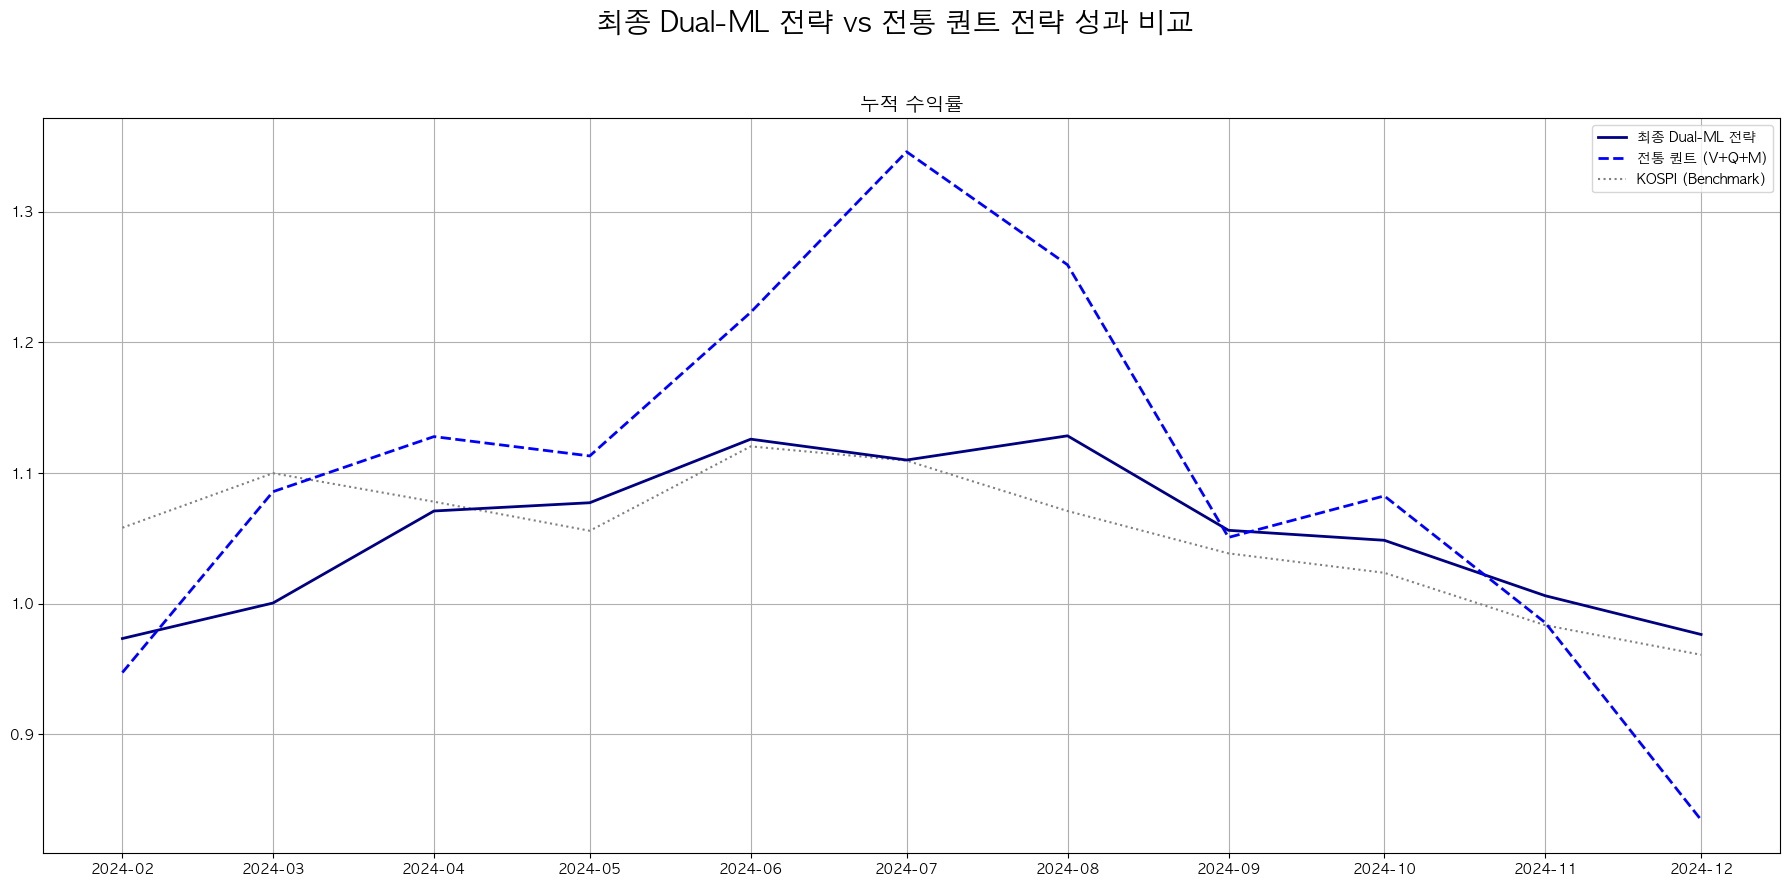

In [6]:
# ÌååÏùº Ïù¥Î¶Ñ: 02_run_comparative_backtest.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# Í≤ΩÍ≥† Î©îÏãúÏßÄ Î¨¥Ïãú
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Í∏∞Î≥∏ Ìè∞Ìä∏Î°ú ÏÑ§Ï†ïÎê©ÎãàÎã§.")
plt.rcParams['axes.unicode_minus'] = False

# --- Ìó¨Ìçº Ìï®Ïàò ---
def get_kospi_data(start_date, end_date):
    """KOSPI Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞Î•º ÏàòÏßëÌï©ÎãàÎã§."""
    print("KOSPI Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'ÏàòÏùµÎ•†': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': 'Í∏∞Ï§ÄÏõî'}, inplace=True)
    kospi_df_monthly['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(kospi_df_monthly['Í∏∞Ï§ÄÏõî']).dt.to_period('M').dt.to_timestamp()
    print("‚úÖ KOSPI Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """ÏÑ±Í≥º ÏßÄÌëúÎ•º Í≥ÑÏÇ∞ÌïòÎäî Ìó¨Ìçº Ìï®Ïàò"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- ÏµúÏ¢Ö ÎπÑÍµê Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§ ---
class FinalComparativeBacktester:
    def __init__(self, ml_dataset, df_with_factors, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_with_factors = df_with_factors
        self.df_original = df_original
        self.top_n, self.cost = top_n, cost
        
        # --- Ïó¨Í∏∞Í∞Ä ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ ---
        # Í≤∞Í≥º Ï†ÄÏû•ÏùÑ ÏúÑÌïú Î≥ÄÏàòÎì§ÏùÑ Î™ÖÌôïÌïòÍ≤å Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
        self.returns_df = None
        self.performance_summary = {} # Ïù¥ Ï§ÑÏù¥ Ï∂îÍ∞ÄÎêòÏóàÏäµÎãàÎã§.

    def run_backtest_comparison(self, train_months=36, test_months=6):
        print(f"Ï†ÑÎûµ ÎπÑÍµê Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (ÌïôÏäµ: {train_months}Í∞úÏõî)...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['Í∏∞Ï§ÄÏõî'].unique())
        returns_ml, returns_traditional = [], []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            print(f"\n--- ÌïôÏäµ: {train_start.strftime('%Y-%m')}~{train_end.strftime('%Y-%m')} | Í≤ÄÏ¶ù: {test_start.strftime('%Y-%m')}~{test_end.strftime('%Y-%m')} ---")
            
            train_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            print("  - ÏïåÌåå Î™®Îç∏ ÌïôÏäµ Ï§ë..."); alpha_model = lgb.LGBMClassifier(random_state=42); alpha_model.fit(X_train, y_alpha_train)
            print("  - Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ ÌïôÏäµ Ï§ë..."); risk_model = lgb.LGBMClassifier(random_state=42); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['Í∏∞Ï§ÄÏõî'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                # --- ML Ï†ÑÎûµ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ---
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(self.top_n * 2, 'alpha_score')
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                portfolio_ml = candidate_stocks.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist()
                
                # --- Ï†ÑÌÜµ ÌÄÄÌä∏ Ï†ÑÎûµ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ---
                current_factors_df = self.df_with_factors[self.df_with_factors['Í∏∞Ï§ÄÏõî'] == date]
                current_factors_df['traditional_score'] = current_factors_df['value_score'] + current_factors_df['quality_score'] + current_factors_df['momentum_score']
                portfolio_traditional = current_factors_df.nlargest(self.top_n, 'traditional_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist()

                # --- Îã§ÏùåÎã¨ ÏàòÏùµÎ•† Í≥ÑÏÇ∞ ---
                next_month_date = date + pd.DateOffset(months=1); next_month_data_orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month_date]
                
                next_month_ml = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(portfolio_ml)]
                returns_ml.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': (next_month_ml['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_ml.empty else -self.cost})
                
                next_month_trad = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(portfolio_traditional)]
                returns_traditional.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': (next_month_trad['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_trad.empty else -self.cost})
            
            current_train_end_idx += test_months
        
        print("\n‚úÖ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!"); 
        df_ml = pd.DataFrame(returns_ml).set_index('Í∏∞Ï§ÄÏõî'); df_trad = pd.DataFrame(returns_traditional).set_index('Í∏∞Ï§ÄÏõî')
        self.returns_df = pd.concat([df_ml, df_trad], axis=1, keys=['Dual-ML Ï†ÑÎûµ', 'Ï†ÑÌÜµ ÌÄÄÌä∏']); self.returns_df.columns = self.returns_df.columns.droplevel(1)
        self.performance_summary['Dual-ML Ï†ÑÎûµ'] = calculate_performance_metrics(self.returns_df['Dual-ML Ï†ÑÎûµ'].dropna())
        self.performance_summary['Ï†ÑÌÜµ ÌÄÄÌä∏'] = calculate_performance_metrics(self.returns_df['Ï†ÑÌÜµ ÌÄÄÌä∏'].dropna())
        self.print_performance_summary()

    def print_performance_summary(self):
        print("\n" + "="*60); print(" " * 20 + "- ÏµúÏ¢Ö ÏÑ±Í≥º ÎπÑÍµê ÏöîÏïΩ -"); print("="*60); 
        summary_df = pd.DataFrame.from_dict(self.performance_summary, orient='index');
        for col in summary_df.columns: summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
    def plot_results(self, kospi_df):
        if self.returns_df is None or self.returns_df.empty: return
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 9)); fig.suptitle('ÏµúÏ¢Ö Dual-ML Ï†ÑÎûµ vs Ï†ÑÌÜµ ÌÄÄÌä∏ Ï†ÑÎûµ ÏÑ±Í≥º ÎπÑÍµê', fontsize=20)
        cum_returns = (1 + self.returns_df.fillna(0)).cumprod(); 
        kospi_returns_aligned = kospi_df.set_index('Í∏∞Ï§ÄÏõî').loc[cum_returns.index]; 
        cum_returns_kospi = (1 + kospi_returns_aligned['ÏàòÏùµÎ•†']).cumprod()
        ax1.plot(cum_returns.index, cum_returns['Dual-ML Ï†ÑÎûµ'], label='ÏµúÏ¢Ö Dual-ML Ï†ÑÎûµ', color='navy', lw=2, zorder=5)
        ax1.plot(cum_returns.index, cum_returns['Ï†ÑÌÜµ ÌÄÄÌä∏'], label='Ï†ÑÌÜµ ÌÄÄÌä∏ (V+Q+M)', color='blue', ls='--', lw=2, zorder=5)
        ax1.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls=':', zorder=4)
        ax1.set_title('ÎàÑÏ†Å ÏàòÏùµÎ•†', fontsize=14); ax1.legend(); ax1.grid(True); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

if __name__ == '__main__':
    print("--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë ---")
    try:
        # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        ml_dataset = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_original = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_with_factors = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/full_feature_stock_data.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        
        # KOSPI Îç∞Ïù¥ÌÑ∞ Î°úÎìú (Ï∫êÏã±)
        kospi_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
            print("‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
        except FileNotFoundError:
            print("‚ö†Ô∏è Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏÉàÎ°ú Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§.")
            start_date, end_date = df_original['Í∏∞Ï§ÄÏõî'].min(), df_original['Í∏∞Ï§ÄÏõî'].max()
            kospi_df = get_kospi_data(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")

        # 2. Î∞±ÌÖåÏä§ÌÑ∞ Ïã§Ìñâ
        train_months = 36
        
        ml_backtester = FinalComparativeBacktester(
            ml_dataset=ml_dataset,
            df_with_factors=df_with_factors, 
            df_original=df_original
        )
        ml_backtester.run_backtest_comparison(train_months=train_months, test_months=6)
        ml_backtester.plot_results(kospi_df)

    except FileNotFoundError as e:
        print(f"\n!!! Ïò§Î•ò: {e} !!!"); print("Î®ºÏ†Ä '01_build_ultimate_dataset.py'Î•º Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")

def plot_metric_comparison(self):
    """Î™®Îç∏Î≥Ñ Ï£ºÏöî ÏÑ±Í≥ºÏßÄÌëú ÏãúÍ∞ÅÌôî"""
    df = pd.DataFrame(self.performance_summary).T
    df = df.rename(columns={"Rank_IC": "Rank IC"})
    df.plot(kind='bar', figsize=(10, 6))
    plt.title("Î™®Îç∏Î≥Ñ ÏÑ±Îä• ÎπÑÍµê (R¬≤, Rank IC, Hit Ratio, Sharpe Ratio)")
    plt.ylabel("Í∞í")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (Î™®Îç∏ ÎπÑÍµê) ---
‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.
‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.
--- Î™®Îç∏: LogisticRegression | Walk-Forward Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linea

--- Î™®Îç∏: RandomForest | Walk-Forward Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ ---
--- Î™®Îç∏: LightGBM | Walk-Forward Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ ---
--- Î™®Îç∏: XGBoost | Walk-Forward Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ ---


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [03:55:28] WARN


                  - Î®∏Ïã†Îü¨Îãù Î™®Îç∏Î≥Ñ ÏµúÏ¢Ö ÏÑ±Í≥º ÎπÑÍµê -
                       CAGR      MDD Volatility Sharpe Ratio
LogisticRegression  -15.88%  -24.03%     25.76%        -0.62
RandomForest        -13.20%  -12.48%      7.41%        -1.78
LightGBM              8.14%   -7.16%     16.28%         0.50
XGBoost             -18.02%  -17.11%     10.70%        -1.68


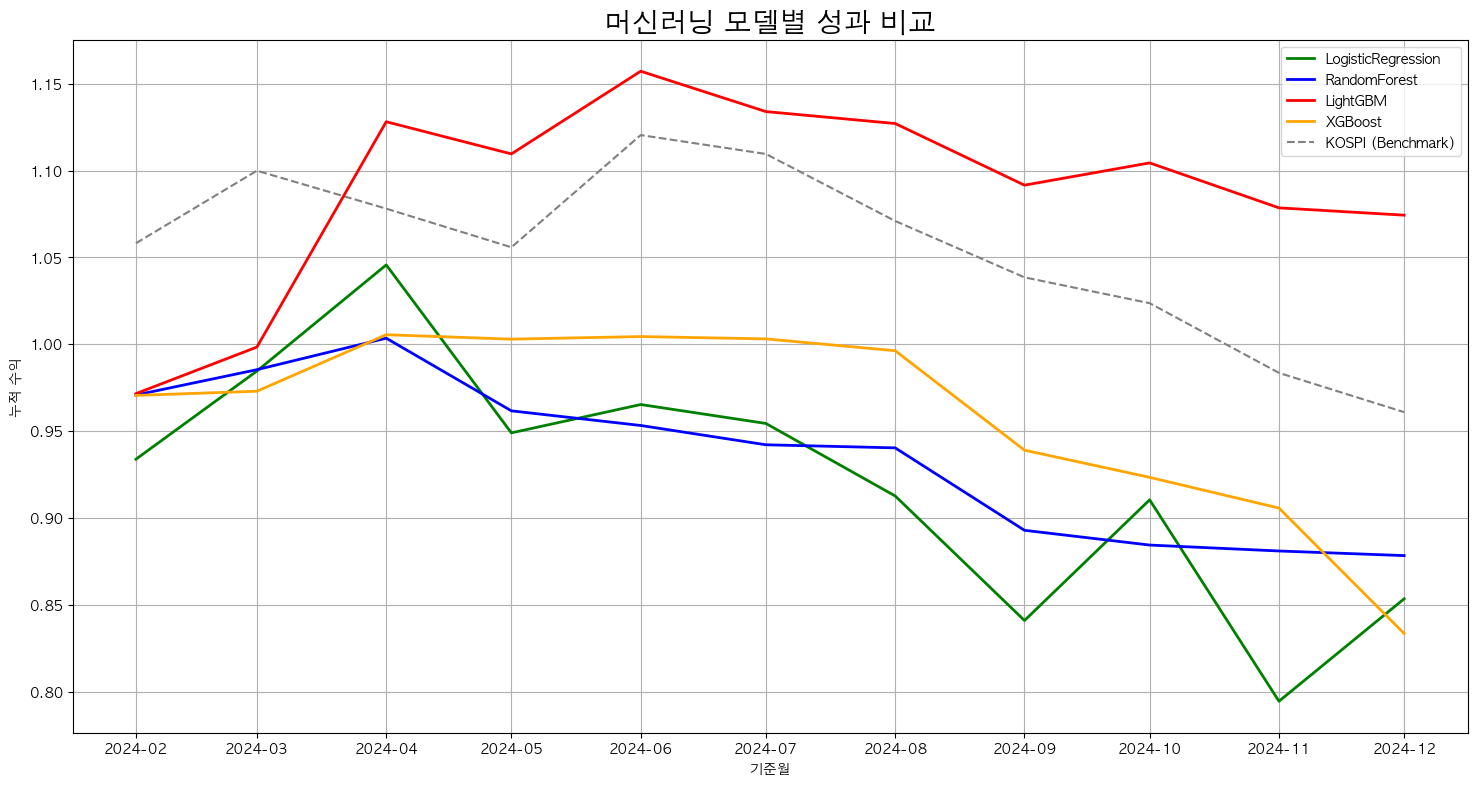

In [7]:
# ÌååÏùº Ïù¥Î¶Ñ: 02_run_model_comparison_final.py
# Ïó≠Ìï†: 3ÎåÄ Î®∏Ïã†Îü¨Îãù Î™®Îç∏(Î°úÏßÄÏä§Ìã± ÌöåÍ∑Ä, ÎûúÎç§ Ìè¨Î†àÏä§Ìä∏, LightGBM, XGBoost)ÏùÑ
#       Î™®Îëê ÏÇ¨Ïö©ÌïòÏó¨ Î∞±ÌÖåÏä§ÌåÖÌïòÍ≥†, Í∑∏ ÏÑ±Í≥ºÎ•º Ï¢ÖÌï©Ï†ÅÏúºÎ°ú ÎπÑÍµê Î∂ÑÏÑùÌïòÎäî ÏµúÏ¢Ö Ïä§ÌÅ¨Î¶ΩÌä∏.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb # XGBoost ÏûÑÌè¨Ìä∏
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ---
try: plt.rc('font', family='AppleGothic')
except: plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# --- Ìó¨Ìçº Ìï®Ïàò ---
def get_kospi_data_for_caching(start_date, end_date):
    """(Ï∫êÏãú ÏÉùÏÑ±Ïö©) KOSPI ÏõîÎ≥Ñ ÏàòÏùµÎ•† Îç∞Ïù¥ÌÑ∞Î•º ÏàòÏßëÌï©ÎãàÎã§."""
    print("KOSPI Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last(); kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'ÏàòÏùµÎ•†': kospi_monthly_returns}).reset_index(); kospi_df_monthly.rename(columns={'Date': 'Í∏∞Ï§ÄÏõî'}, inplace=True)
    kospi_df_monthly['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(kospi_df_monthly['Í∏∞Ï§ÄÏõî']).dt.to_period('M').dt.to_timestamp()
    print("‚úÖ KOSPI Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """ÏÑ±Í≥º ÏßÄÌëúÎ•º Í≥ÑÏÇ∞ÌïòÎäî Ìó¨Ìçº Ìï®Ïàò"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- ÏµúÏ¢Ö ÎπÑÍµê Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§ ---
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset; self.df_original = df_original
        self.top_n, self.cost = top_n, cost

    def run_walk_forward_backtest(self, alpha_model, risk_model, model_name, train_months=36, test_months=6):
        """ÌôïÏû• ÏúàÎèÑÏö∞ Î∞©ÏãùÏúºÎ°ú Ï£ºÏñ¥ÏßÑ ÎìÄÏñº ML Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÍ≥† Î∞±ÌÖåÏä§Ìä∏ ÏàòÏùµÎ•†ÏùÑ Î∞òÌôòÌï©ÎãàÎã§."""
        print(f"--- Î™®Îç∏: {model_name} | Walk-Forward Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ ---")
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['Í∏∞Ï§ÄÏõî'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            train_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            alpha_model.fit(X_train, y_alpha_train); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['Í∏∞Ï§ÄÏõî'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(50, 'alpha_score') # Ïù¥ Î∂ÄÎ∂ÑÏùÑ ÏàòÏ†ï
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist()
                
                next_month_date = date + pd.DateOffset(months=1); next_month_data_orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('Í∏∞Ï§ÄÏõî')['ÏàòÏùµÎ•†']

# --- Î©îÏù∏ Ïã§Ìñâ Î∏îÎ°ù ---
if __name__ == '__main__':
    print("--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (Î™®Îç∏ ÎπÑÍµê) ---")
    try:
        # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        ml_dataset = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_original = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        
        kospi_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
            print("‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
        except FileNotFoundError:
            print("‚ö†Ô∏è Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏÉàÎ°ú Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§.")
            start_date, end_date = df_original['Í∏∞Ï§ÄÏõî'].min(), df_original['Í∏∞Ï§ÄÏõî'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")

        # 2. Î∞±ÌÖåÏä§ÌÑ∞ Í∞ùÏ≤¥ ÏÉùÏÑ±
        backtester = DualMachineLearningBacktester(ml_dataset=ml_dataset, df_original=df_original)
        
        # 3. ÎπÑÍµêÌï† Î™®Îç∏Îì§ Ï†ïÏùò
        models_to_test = {
            'LogisticRegression': (LogisticRegression(random_state=42, max_iter=1000), LogisticRegression(random_state=42, max_iter=1000)),
            'RandomForest': (RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
            'LightGBM': (lgb.LGBMClassifier(random_state=42, verbosity=-1), lgb.LGBMClassifier(random_state=42, verbosity=-1)),
            'XGBoost': (xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        }
        
        all_results = {}; all_returns = {}; train_months = 36

        # 4. Í∞Å Î™®Îç∏Ïóê ÎåÄÌï¥ Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ
        for name, (alpha_model, risk_model) in models_to_test.items():
            returns = backtester.run_walk_forward_backtest(alpha_model, risk_model, name, train_months=train_months, test_months=6)
            all_returns[name] = returns; all_results[name] = calculate_performance_metrics(returns)
        
        # 5. ÏµúÏ¢Ö Í≤∞Í≥º ÎπÑÍµê Ï∂úÎ†•
        print("\n" + "="*60); print(" " * 18 + "- Î®∏Ïã†Îü¨Îãù Î™®Îç∏Î≥Ñ ÏµúÏ¢Ö ÏÑ±Í≥º ÎπÑÍµê -"); print("="*60)
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')
        for col in summary_df.columns:
            summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
        # 6. ÏµúÏ¢Ö Í≤∞Í≥º ÏãúÍ∞ÅÌôî
        returns_df_all = pd.concat(all_returns, axis=1); cum_returns = (1 + returns_df_all.fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('Í∏∞Ï§ÄÏõî').loc[cum_returns.index]; cum_returns_kospi = (1 + kospi_returns_aligned['ÏàòÏùµÎ•†']).cumprod()
        
        plt.figure(figsize=(18, 9)); plt.title('Î®∏Ïã†Îü¨Îãù Î™®Îç∏Î≥Ñ ÏÑ±Í≥º ÎπÑÍµê', fontsize=20)
        colors = {'LogisticRegression': 'green', 'RandomForest': 'blue', 'LightGBM': 'red', 'XGBoost': 'orange'}
        for name in models_to_test.keys():
            plt.plot(cum_returns.index, cum_returns[name], label=name, color=colors.get(name), lw=2, zorder=5)
            
        plt.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        plt.ylabel('ÎàÑÏ†Å ÏàòÏùµ'); plt.xlabel('Í∏∞Ï§ÄÏõî'); plt.legend(); plt.grid(True); plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! Ïò§Î•ò: {e} !!!"); print("Î®ºÏ†Ä '01_build_ultimate_dataset.py'Î•º Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")


--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (LightGBM Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÇ¨Ïù¥Ï¶à ÎπÑÍµê) ---
‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.
‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.

Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò: 15Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë
ÎìÄÏñº LightGBM ÌôïÏû• ÏúàÎèÑÏö∞ Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (Ï¢ÖÎ™© Ïàò: 15)...
--- ÌïôÏäµ: 2021-01~2023-12 | Í≤ÄÏ¶ù: 2024-01~2024-06 ---
--- ÌïôÏäµ: 2021-01~2024-06 | Í≤ÄÏ¶ù: 2024-07~2024-11 ---

Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò: 16Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë
ÎìÄÏñº LightGBM ÌôïÏû• ÏúàÎèÑÏö∞ Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (Ï¢ÖÎ™© Ïàò: 16)...
--- ÌïôÏäµ: 2021-01~2023-12 | Í≤ÄÏ¶ù: 2024-01~2024-06 ---
--- ÌïôÏäµ: 2021-01~2024-06 | Í≤ÄÏ¶ù: 2024-07~2024-11 ---

Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò: 17Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë
ÎìÄÏñº LightGBM ÌôïÏû• ÏúàÎèÑÏö∞ Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (Ï¢ÖÎ™© Ïàò: 17)...
--- ÌïôÏäµ: 2021-01~2023-12 | Í≤ÄÏ¶ù: 2024-01~2024-06 ---
--- ÌïôÏäµ: 2021-01~2024-06 | Í≤ÄÏ¶ù: 2024-07~2024-11 ---

Ìè¨Ìä∏Ìè

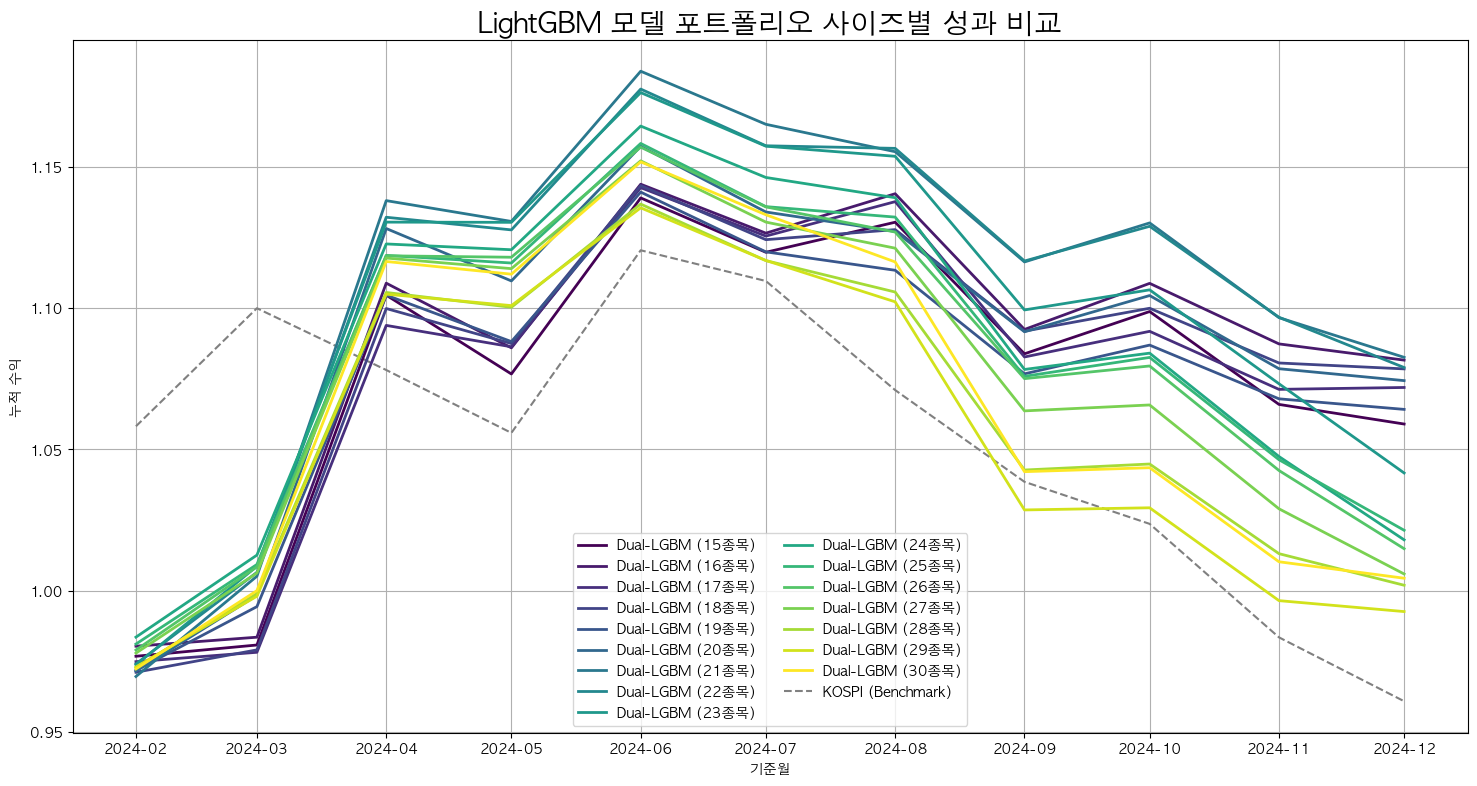

In [15]:
# ÌååÏùº Ïù¥Î¶Ñ: 02_run_lightgbm_comparison.py
# Ïó≠Ìï†: ÎØ∏Î¶¨ ÏÉùÏÑ±Îêú Îç∞Ïù¥ÌÑ∞ÏÖãÏùÑ Î∂àÎü¨ÏôÄ, LightGBM Î™®Îç∏ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨
#       Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÇ¨Ïù¥Ï¶à(15~30Í∞ú)Î≥Ñ ÏÑ±Í≥ºÎ•º ÎπÑÍµê Î∂ÑÏÑùÌïòÎäî ÏµúÏ¢Ö Ïä§ÌÅ¨Î¶ΩÌä∏.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb # XGBoost -> LightGBMÏúºÎ°ú Î≥ÄÍ≤Ω
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# Í≤ΩÍ≥† Î©îÏãúÏßÄ Î¨¥Ïãú
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Í∏∞Î≥∏ Ìè∞Ìä∏Î°ú ÏÑ§Ï†ïÎê©ÎãàÎã§.")
plt.rcParams['axes.unicode_minus'] = False

# --- Ìó¨Ìçº Ìï®Ïàò ---
def get_kospi_data_for_caching(start_date, end_date):
    """(Ï∫êÏãú ÏÉùÏÑ±Ïö©) KOSPI ÏõîÎ≥Ñ ÏàòÏùµÎ•† Îç∞Ïù¥ÌÑ∞Î•º ÏàòÏßëÌï©ÎãàÎã§."""
    print("KOSPI Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§...");
    safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'ÏàòÏùµÎ•†': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': 'Í∏∞Ï§ÄÏõî'}, inplace=True)
    kospi_df_monthly['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(kospi_df_monthly['Í∏∞Ï§ÄÏõî']).dt.to_period('M').dt.to_timestamp()
    print("‚úÖ KOSPI Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!")
    return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """ÏÑ±Í≥º ÏßÄÌëúÎ•º Í≥ÑÏÇ∞ÌïòÎäî Ìó¨Ìçº Ìï®Ïàò"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- ÏµúÏ¢Ö Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§ ---
class DualMachineLearningBacktester:
    """ÏïåÌåå Î™®Îç∏Í≥º Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ÏùÑ Í≤∞Ìï©Ìïú Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§."""
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        """ÌôïÏû• ÏúàÎèÑÏö∞ Î∞©ÏãùÏúºÎ°ú ÎìÄÏñº LightGBM Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÍ≥† Î∞±ÌÖåÏä§Ìä∏ ÏàòÏùµÎ•†ÏùÑ Î∞òÌôòÌï©ÎãàÎã§."""
        print(f"ÎìÄÏñº LightGBM ÌôïÏû• ÏúàÎèÑÏö∞ Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (Ï¢ÖÎ™© Ïàò: {self.top_n})...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['Í∏∞Ï§ÄÏõî'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            print(f"--- ÌïôÏäµ: {train_start.strftime('%Y-%m')}~{train_end.strftime('%Y-%m')} | Í≤ÄÏ¶ù: {test_start.strftime('%Y-%m')}~{test_end.strftime('%Y-%m')} ---")
            
            train_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            # Î™®Îç∏ÏùÑ LightGBMÏúºÎ°ú Î≥ÄÍ≤Ω
            alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
            risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['Í∏∞Ï§ÄÏõî'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(50, 'alpha_score') # ÏïåÌåå Î™®Îç∏Ïù¥ 50Í∞ú Ï∂îÏ≤ú
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist() # Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïù¥ ÏµúÏ¢Ö top_nÍ∞ú ÏÑ†ÌÉù
                
                next_month_date = date + pd.DateOffset(months=1)
                next_month_data_orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('Í∏∞Ï§ÄÏõî')['ÏàòÏùµÎ•†']

# --- Î©îÏù∏ Ïã§Ìñâ Î∏îÎ°ù ---
if __name__ == '__main__':
    print("--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (LightGBM Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÇ¨Ïù¥Ï¶à ÎπÑÍµê) ---")
    try:
        # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        ml_dataset = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_original = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        
        kospi_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
            print("‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
        except FileNotFoundError:
            print("‚ö†Ô∏è Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏÉàÎ°ú Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§.")
            start_date, end_date = df_original['Í∏∞Ï§ÄÏõî'].min(), df_original['Í∏∞Ï§ÄÏõî'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")

        # 2. ÎπÑÍµêÌï† ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
        portfolio_sizes_to_test = list(range(15, 31)) # 15Î∂ÄÌÑ∞ 30ÍπåÏßÄ Î™®Îì† Ï†ïÏàò
        train_months = 36
        
        all_results = {}
        all_returns = {}

        # 3. Í∞Å Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÇ¨Ïù¥Ï¶àÎ≥ÑÎ°ú Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ
        for n_stocks in portfolio_sizes_to_test:
            print(f"\n" + "="*80); print(f"Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò: {n_stocks}Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë"); print("="*80)
            
            backtester = DualMachineLearningBacktester(
                ml_dataset=ml_dataset, 
                df_original=df_original,
                top_n=n_stocks
            )
            returns = backtester.run_walk_forward_backtest(train_months=train_months, test_months=6)
            
            strategy_name = f'Dual-LGBM ({n_stocks}Ï¢ÖÎ™©)' # Î™®Îç∏ Ïù¥Î¶Ñ Î≥ÄÍ≤Ω
            all_returns[strategy_name] = returns
            all_results[strategy_name] = calculate_performance_metrics(returns)

        # 4. ÏµúÏ¢Ö Í≤∞Í≥º ÎπÑÍµê Ï∂úÎ†•
        print("\n" + "="*60); print(" " * 15 + "- Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÇ¨Ïù¥Ï¶àÎ≥Ñ ÏµúÏ¢Ö ÏÑ±Í≥º ÎπÑÍµê -"); print("="*60)
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')
        for col in summary_df.columns:
            summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}" if col != 'Sharpe Ratio' else f"{x:.2f}")
        print(summary_df); print("="*60)
        
        # 5. ÏµúÏ¢Ö Í≤∞Í≥º ÏãúÍ∞ÅÌôî
        returns_df_all = pd.concat(all_returns, axis=1)
        cum_returns = (1 + returns_df_all.fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('Í∏∞Ï§ÄÏõî').loc[cum_returns.index]
        cum_returns_kospi = (1 + kospi_returns_aligned['ÏàòÏùµÎ•†']).cumprod()
        
        plt.figure(figsize=(18, 9))
        plt.title('LightGBM Î™®Îç∏ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÇ¨Ïù¥Ï¶àÎ≥Ñ ÏÑ±Í≥º ÎπÑÍµê', fontsize=20)
        
        colormap = plt.cm.viridis(np.linspace(0, 1, len(cum_returns.columns)))
        for i, name in enumerate(cum_returns.columns):
            plt.plot(cum_returns.index, cum_returns[name], label=name, color=colormap[i], lw=2, zorder=5)
            
        plt.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        plt.ylabel('ÎàÑÏ†Å ÏàòÏùµ'); plt.xlabel('Í∏∞Ï§ÄÏõî'); plt.legend(ncol=2); plt.grid(True); plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! Ïò§Î•ò: {e} !!!"); print("Î®ºÏ†Ä '01_build_ultimate_dataset.py'Î•º Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")


--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (LightGBM Í∑∏Î¶¨Îìú ÏÑúÏπò) ---
‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.
‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.

################################################################################
## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: 50Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##
################################################################################


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:   0%|          | 0/16 [00:00<?, ?it/s]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 15) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:   6%|‚ñã         | 1/16 [00:02<00:30,  2.06s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 16) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  12%|‚ñà‚ñé        | 2/16 [00:04<00:28,  2.05s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 17) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  19%|‚ñà‚ñâ        | 3/16 [00:06<00:26,  2.06s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 18) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  25%|‚ñà‚ñà‚ñå       | 4/16 [00:08<00:25,  2.11s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 19) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  31%|‚ñà‚ñà‚ñà‚ñè      | 5/16 [00:10<00:23,  2.09s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 20) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  38%|‚ñà‚ñà‚ñà‚ñä      | 6/16 [00:12<00:20,  2.08s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 21) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7/16 [00:14<00:18,  2.06s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 22) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 8/16 [00:16<00:16,  2.06s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 23) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 9/16 [00:18<00:14,  2.04s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 24) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 10/16 [00:20<00:12,  2.01s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 11/16 [00:22<00:09,  1.97s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 26) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 12/16 [00:24<00:07,  1.95s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 27) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 13/16 [00:26<00:05,  1.93s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 28) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 14/16 [00:28<00:03,  1.92s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 29) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 15/16 [00:29<00:01,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 50, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 30) ---


ÌõÑÎ≥¥Íµ∞ 50Í∞ú ÏßÑÌñâÎ•†: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:31<00:00,  1.99s/it]



################################################################################
## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: 100Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##
################################################################################


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:   0%|          | 0/16 [00:00<?, ?it/s]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 15) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:   6%|‚ñã         | 1/16 [00:01<00:29,  1.95s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 16) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  12%|‚ñà‚ñé        | 2/16 [00:03<00:26,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 17) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  19%|‚ñà‚ñâ        | 3/16 [00:05<00:24,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 18) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  25%|‚ñà‚ñà‚ñå       | 4/16 [00:07<00:22,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 19) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  31%|‚ñà‚ñà‚ñà‚ñè      | 5/16 [00:09<00:20,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 20) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  38%|‚ñà‚ñà‚ñà‚ñä      | 6/16 [00:11<00:18,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 21) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7/16 [00:13<00:17,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 22) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 8/16 [00:15<00:15,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 23) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 9/16 [00:17<00:13,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 24) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 10/16 [00:19<00:11,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 11/16 [00:20<00:09,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 26) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 12/16 [00:22<00:07,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 27) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 13/16 [00:24<00:05,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 28) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 14/16 [00:26<00:03,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 29) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 15/16 [00:28<00:01,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 100, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 30) ---


ÌõÑÎ≥¥Íµ∞ 100Í∞ú ÏßÑÌñâÎ•†: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:30<00:00,  1.90s/it]



################################################################################
## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: 150Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##
################################################################################


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:   0%|          | 0/16 [00:00<?, ?it/s]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 15) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:   6%|‚ñã         | 1/16 [00:01<00:29,  1.94s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 16) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  12%|‚ñà‚ñé        | 2/16 [00:03<00:26,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 17) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  19%|‚ñà‚ñâ        | 3/16 [00:05<00:24,  1.92s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 18) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  25%|‚ñà‚ñà‚ñå       | 4/16 [00:07<00:22,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 19) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  31%|‚ñà‚ñà‚ñà‚ñè      | 5/16 [00:09<00:20,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 20) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  38%|‚ñà‚ñà‚ñà‚ñä      | 6/16 [00:11<00:18,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 21) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7/16 [00:13<00:17,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 22) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 8/16 [00:15<00:15,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 23) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 9/16 [00:17<00:13,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 24) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 10/16 [00:18<00:11,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 11/16 [00:20<00:09,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 26) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 12/16 [00:22<00:07,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 27) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 13/16 [00:24<00:05,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 28) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 14/16 [00:26<00:03,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 29) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 15/16 [00:28<00:01,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 150, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 30) ---


ÌõÑÎ≥¥Íµ∞ 150Í∞ú ÏßÑÌñâÎ•†: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:30<00:00,  1.90s/it]



################################################################################
## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: 200Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##
################################################################################


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:   0%|          | 0/16 [00:00<?, ?it/s]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 15) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:   6%|‚ñã         | 1/16 [00:01<00:28,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 16) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  12%|‚ñà‚ñé        | 2/16 [00:03<00:26,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 17) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  19%|‚ñà‚ñâ        | 3/16 [00:05<00:24,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 18) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  25%|‚ñà‚ñà‚ñå       | 4/16 [00:07<00:22,  1.88s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 19) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  31%|‚ñà‚ñà‚ñà‚ñè      | 5/16 [00:09<00:20,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 20) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  38%|‚ñà‚ñà‚ñà‚ñä      | 6/16 [00:11<00:18,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 21) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7/16 [00:13<00:16,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 22) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 8/16 [00:15<00:15,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 23) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 9/16 [00:16<00:13,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 24) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 10/16 [00:18<00:11,  1.88s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 11/16 [00:20<00:09,  1.88s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 26) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 12/16 [00:22<00:07,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 27) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 13/16 [00:24<00:05,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 28) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 14/16 [00:26<00:03,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 29) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 15/16 [00:28<00:01,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 200, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 30) ---


ÌõÑÎ≥¥Íµ∞ 200Í∞ú ÏßÑÌñâÎ•†: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:30<00:00,  1.89s/it]



################################################################################
## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: 250Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##
################################################################################


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:   0%|          | 0/16 [00:00<?, ?it/s]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 15) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:   6%|‚ñã         | 1/16 [00:01<00:28,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 16) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  12%|‚ñà‚ñé        | 2/16 [00:03<00:26,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 17) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  19%|‚ñà‚ñâ        | 3/16 [00:05<00:24,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 18) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  25%|‚ñà‚ñà‚ñå       | 4/16 [00:07<00:22,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 19) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  31%|‚ñà‚ñà‚ñà‚ñè      | 5/16 [00:09<00:20,  1.88s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 20) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  38%|‚ñà‚ñà‚ñà‚ñä      | 6/16 [00:11<00:18,  1.88s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 21) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7/16 [00:13<00:17,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 22) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 8/16 [00:15<00:15,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 23) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 9/16 [00:17<00:13,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 24) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 10/16 [00:18<00:11,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 11/16 [00:20<00:09,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 26) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 12/16 [00:22<00:07,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 27) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 13/16 [00:24<00:05,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 28) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 14/16 [00:26<00:03,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 29) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 15/16 [00:28<00:01,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 250, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 30) ---


ÌõÑÎ≥¥Íµ∞ 250Í∞ú ÏßÑÌñâÎ•†: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:30<00:00,  1.90s/it]



################################################################################
## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: 300Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##
################################################################################


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:   0%|          | 0/16 [00:00<?, ?it/s]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 15) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:   6%|‚ñã         | 1/16 [00:01<00:28,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 16) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  12%|‚ñà‚ñé        | 2/16 [00:03<00:26,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 17) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  19%|‚ñà‚ñâ        | 3/16 [00:05<00:24,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 18) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  25%|‚ñà‚ñà‚ñå       | 4/16 [00:07<00:22,  1.89s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 19) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  31%|‚ñà‚ñà‚ñà‚ñè      | 5/16 [00:09<00:20,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 20) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  38%|‚ñà‚ñà‚ñà‚ñä      | 6/16 [00:11<00:18,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 21) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  44%|‚ñà‚ñà‚ñà‚ñà‚ñç     | 7/16 [00:13<00:17,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 22) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 8/16 [00:15<00:15,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 23) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 9/16 [00:17<00:13,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 24) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 10/16 [00:19<00:11,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 11/16 [00:20<00:09,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 26) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 12/16 [00:22<00:07,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 27) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 13/16 [00:24<00:05,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 28) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 14/16 [00:26<00:03,  1.91s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 29) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 15/16 [00:28<00:01,  1.90s/it]

--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: 300, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 30) ---


ÌõÑÎ≥¥Íµ∞ 300Í∞ú ÏßÑÌñâÎ•†: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 16/16 [00:30<00:00,  1.90s/it]


               üèÜ Sharpe Ratio Í∏∞Ï§Ä ÏÉÅÏúÑ 10Í∞ú Ïö∞Ïàò Ï°∞Ìï© üèÜ
              CAGR     MDD Volatility Sharpe Ratio
ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö25  8.04%  -4.59%     11.24%         0.71
ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö24  7.38%  -5.10%     11.02%         0.67
ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö26  6.51%  -4.47%     11.07%         0.59
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö18   8.59%  -5.67%     15.45%         0.56
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö16   8.93%  -5.44%     16.22%         0.55
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö22   8.64%  -8.37%     15.99%         0.54
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö21   9.04%  -8.55%     16.93%         0.53
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö17   7.87%  -6.25%     15.44%         0.51
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö20   8.14%  -7.16%     16.28%         0.50
ÌõÑÎ≥¥Íµ∞50_ÏµúÏ¢Ö19   7.02%  -6.74%     14.53%         0.48


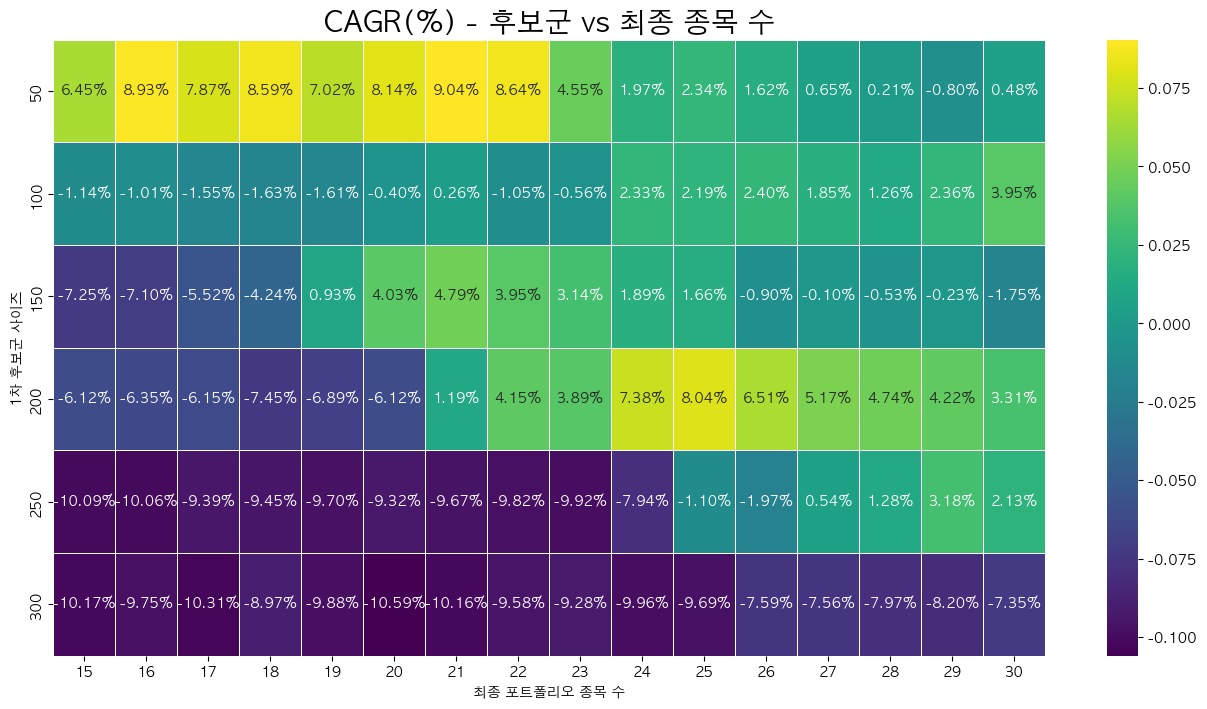

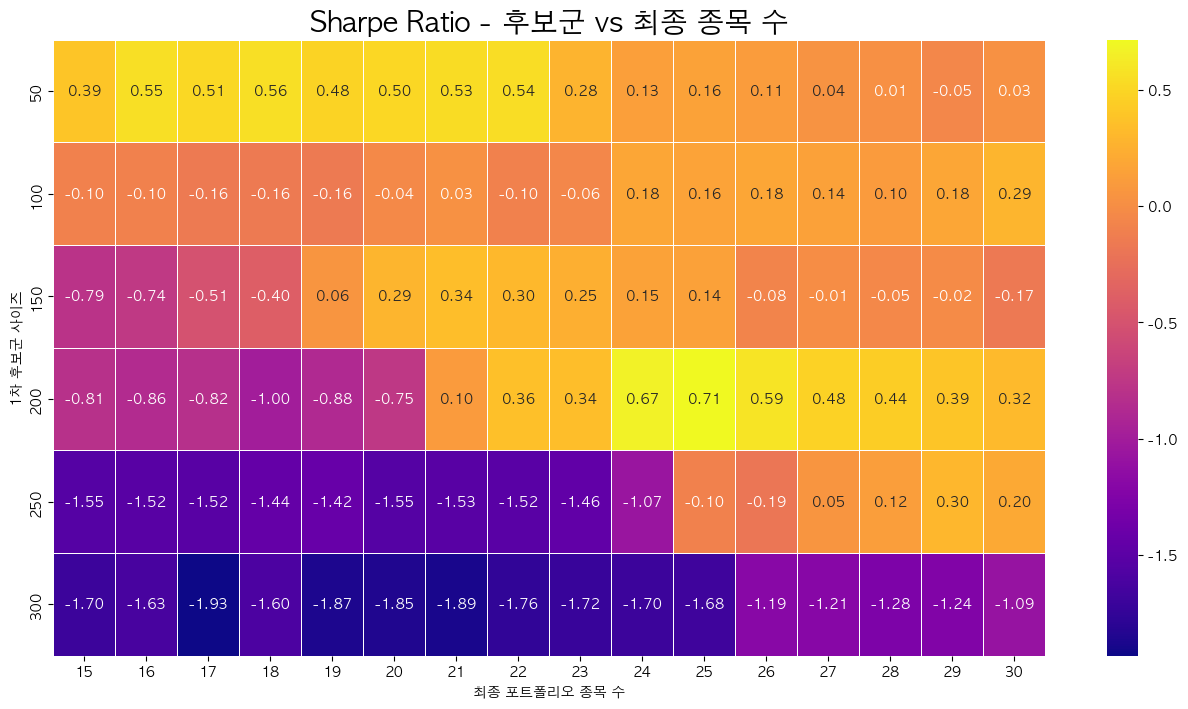

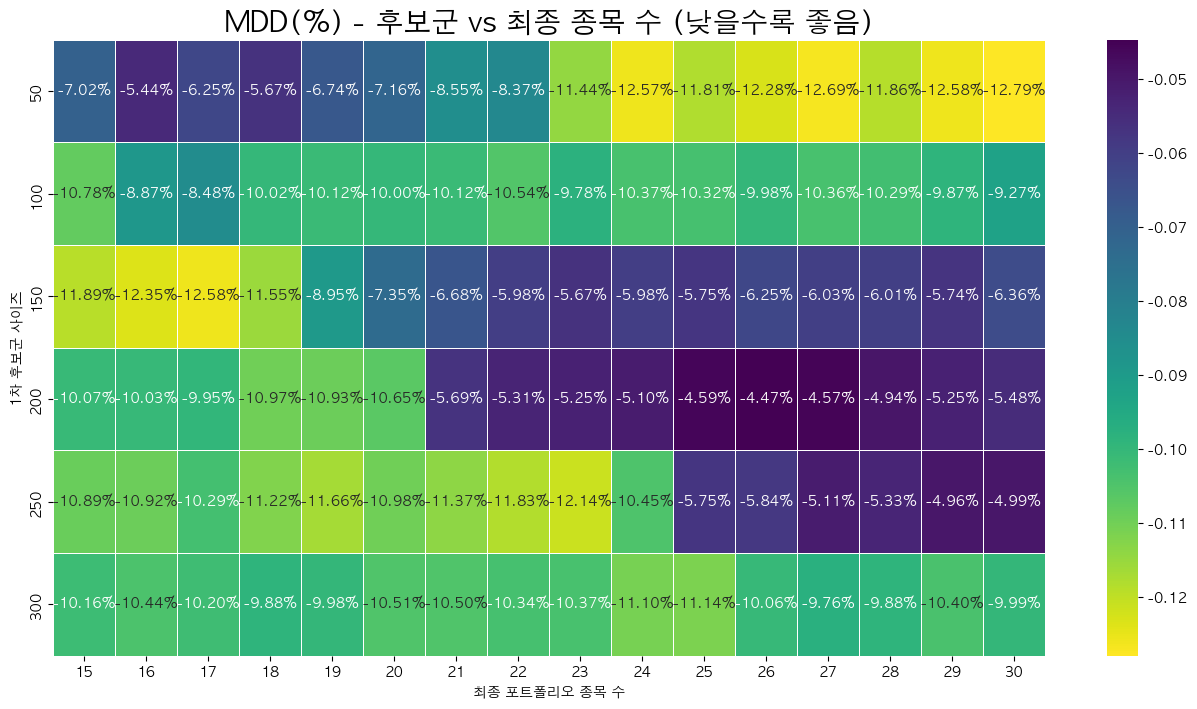

In [8]:
# ÌååÏùº Ïù¥Î¶Ñ: 02_run_lightgbm_grid_search_final.py
# Ïó≠Ìï†: LightGBM Î™®Îç∏ Í∑∏Î¶¨Îìú ÏÑúÏπòÎ•º ÏàòÌñâÌïòÍ≥†, ÏÉ§ÌîÑ ÏßÄÏàò Í∏∞Ï§Ä ÏÉÅÏúÑ 10Í∞ú Ï°∞Ìï©ÏùÑ Ï∂îÏ∂úÌïòÎ©∞,
#       CAGR, Sharpe Ratio, MDDÎ•º ÌûàÌä∏ÎßµÏúºÎ°ú ÏãúÍ∞ÅÌôîÌïòÎäî ÏµúÏ¢Ö Ïä§ÌÅ¨Î¶ΩÌä∏.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings

# Í≤ΩÍ≥† Î©îÏãúÏßÄ Î¨¥Ïãú
warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Í∏∞Î≥∏ Ìè∞Ìä∏Î°ú ÏÑ§Ï†ïÎê©ÎãàÎã§.")
plt.rcParams['axes.unicode_minus'] = False

# --- Ìó¨Ìçº Ìï®Ïàò ---
def get_kospi_data_for_caching(start_date, end_date):
    """(Ï∫êÏãú ÏÉùÏÑ±Ïö©) KOSPI ÏõîÎ≥Ñ ÏàòÏùµÎ•† Îç∞Ïù¥ÌÑ∞Î•º ÏàòÏßëÌï©ÎãàÎã§."""
    print("KOSPI Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§...");
    safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'ÏàòÏùµÎ•†': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': 'Í∏∞Ï§ÄÏõî'}, inplace=True)
    kospi_df_monthly['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(kospi_df_monthly['Í∏∞Ï§ÄÏõî']).dt.to_period('M').dt.to_timestamp()
    print("‚úÖ KOSPI Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!")
    return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    """ÏÑ±Í≥º ÏßÄÌëúÎ•º Í≥ÑÏÇ∞ÌïòÎäî Ìó¨Ìçº Ìï®Ïàò"""
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- ÏµúÏ¢Ö Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§ ---
class DualMachineLearningBacktester:
    """ÏïåÌåå Î™®Îç∏Í≥º Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ÏùÑ Í≤∞Ìï©Ìïú Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§."""
    def __init__(self, ml_dataset, df_original, top_n=20, candidate_pool_size=50, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.candidate_pool_size = candidate_pool_size
        self.cost = cost

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        """ÌôïÏû• ÏúàÎèÑÏö∞ Î∞©ÏãùÏúºÎ°ú ÎìÄÏñº LightGBM Î™®Îç∏ÏùÑ ÌïôÏäµÌïòÍ≥† Î∞±ÌÖåÏä§Ìä∏ ÏàòÏùµÎ•†ÏùÑ Î∞òÌôòÌï©ÎãàÎã§."""
        print(f"--- Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ (ÌõÑÎ≥¥Íµ∞: {self.candidate_pool_size}, ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: {self.top_n}) ---")
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['Í∏∞Ï§ÄÏõî'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        while current_train_end_idx < len(unique_dates):
            train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
            test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
            if test_start > test_end: break

            train_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)]
            features = [col for col in dataset.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]
            X_train, y_alpha_train, y_risk_train = train_data[features], train_data['y_alpha'], train_data['y_risk']
            
            alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
            risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)

            for date in pd.date_range(test_start, test_end, freq='MS'):
                current_month_data = dataset[dataset['Í∏∞Ï§ÄÏõî'] == date].copy()
                if current_month_data.empty: continue
                X_test = current_month_data[features]
                
                current_month_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                candidate_stocks = current_month_data.nlargest(self.candidate_pool_size, 'alpha_score')
                X_candidates = candidate_stocks[features]
                candidate_stocks['risk_score'] = risk_model.predict_proba(X_candidates)[:, 1]
                final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist()
                
                next_month_date = date + pd.DateOffset(months=1)
                next_month_data_orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month_date]
                next_month_returns = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(final_portfolio_stocks)]
                monthly_return = (next_month_returns['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                monthly_returns.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': monthly_return})
            
            current_train_end_idx += test_months
        
        return pd.DataFrame(monthly_returns).set_index('Í∏∞Ï§ÄÏõî')['ÏàòÏùµÎ•†']

# --- Î©îÏù∏ Ïã§Ìñâ Î∏îÎ°ù ---
if __name__ == '__main__':
    print("--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (LightGBM Í∑∏Î¶¨Îìú ÏÑúÏπò) ---")
    try:
        # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        ml_dataset = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_original = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        
        kospi_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
            print("‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
        except FileNotFoundError:
            print("‚ö†Ô∏è Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏÉàÎ°ú Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§.")
            start_date, end_date = df_original['Í∏∞Ï§ÄÏõî'].min(), df_original['Í∏∞Ï§ÄÏõî'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")

        # 2. Í∑∏Î¶¨Îìú ÏÑúÏπòÎ•º ÏúÑÌïú ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï
        candidate_pool_sizes = [50, 100, 150, 200, 250, 300]
        portfolio_sizes_to_test = list(range(15, 31))
        train_months = 36
        
        all_results = {}
        
        # 3. Ïù¥Ï§ë Î∞òÎ≥µÎ¨∏ÏùÑ ÏÇ¨Ïö©Ìïú Í∑∏Î¶¨Îìú ÏÑúÏπò Ïã§Ìñâ
        for pool_size in candidate_pool_sizes:
            print(f"\n" + "#"*80)
            print(f"## 1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à: {pool_size}Í∞ú ÌÖåÏä§Ìä∏ ÏãúÏûë ##")
            print("#"*80)

            for n_stocks in tqdm(portfolio_sizes_to_test, desc=f"ÌõÑÎ≥¥Íµ∞ {pool_size}Í∞ú ÏßÑÌñâÎ•†"):
                if n_stocks >= pool_size: continue

                backtester = DualMachineLearningBacktester(
                    ml_dataset=ml_dataset, 
                    df_original=df_original,
                    top_n=n_stocks,
                    candidate_pool_size=pool_size
                )
                returns = backtester.run_walk_forward_backtest(train_months=train_months, test_months=6)
                
                strategy_name = f'ÌõÑÎ≥¥Íµ∞{pool_size}_ÏµúÏ¢Ö{n_stocks}'
                all_results[strategy_name] = calculate_performance_metrics(returns)

        # 4. ÏµúÏ¢Ö Í≤∞Í≥º ÏöîÏïΩ Î∞è Ïö∞Ïàò Ï°∞Ìï© Ï∂îÏ∂ú
        summary_df = pd.DataFrame.from_dict(all_results, orient='index')

        # ### Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ ###: Sharpe Ratio Í∏∞Ï§Ä ÏÉÅÏúÑ 10Í∞ú Ïö∞Ïàò Ï°∞Ìï© Ï∂îÏ∂ú Î∞è Ï∂úÎ†•
        print("\n" + "="*70)
        print(" " * 15 + "üèÜ Sharpe Ratio Í∏∞Ï§Ä ÏÉÅÏúÑ 10Í∞ú Ïö∞Ïàò Ï°∞Ìï© üèÜ")
        print("="*70)
        
        top_10_df = summary_df.sort_values(by='Sharpe Ratio', ascending=False).head(10).copy()
        
        # Î≥¥Í∏∞ Ï¢ãÍ≤å Ìè¨Îß∑ÌåÖ
        top_10_df['CAGR'] = top_10_df['CAGR'].apply(lambda x: f"{x:.2%}")
        top_10_df['MDD'] = top_10_df['MDD'].apply(lambda x: f"{x:.2%}")
        top_10_df['Volatility'] = top_10_df['Volatility'].apply(lambda x: f"{x:.2%}")
        top_10_df['Sharpe Ratio'] = top_10_df['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")
        
        print(top_10_df)
        print("="*70)
        
        
        # 5. ÏµúÏ¢Ö Í≤∞Í≥º ÌûàÌä∏Îßµ ÏãúÍ∞ÅÌôî
        summary_df['ÌõÑÎ≥¥Íµ∞'] = summary_df.index.map(lambda x: int(x.split('_')[0].replace('ÌõÑÎ≥¥Íµ∞','')))
        summary_df['ÏµúÏ¢ÖÏ¢ÖÎ™©Ïàò'] = summary_df.index.map(lambda x: int(x.split('_')[1].replace('ÏµúÏ¢Ö','')))
        
        # Ïó∞ÌèâÍ∑†Î≥µÎ¶¨ÏàòÏùµÎ•†(CAGR) ÌûàÌä∏Îßµ
        cagr_pivot = summary_df.pivot(index='ÌõÑÎ≥¥Íµ∞', columns='ÏµúÏ¢ÖÏ¢ÖÎ™©Ïàò', values='CAGR')
        plt.figure(figsize=(16, 8))
        sns.heatmap(cagr_pivot, annot=True, fmt='.2%', cmap='viridis', linewidths=.5)
        plt.title('CAGR(%) - ÌõÑÎ≥¥Íµ∞ vs ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò', fontsize=20)
        plt.xlabel('ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò')
        plt.ylabel('1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à')
        plt.show()

        # ÏÉ§ÌîÑ ÎπÑÏú®(Sharpe Ratio) ÌûàÌä∏Îßµ
        sharpe_pivot = summary_df.pivot(index='ÌõÑÎ≥¥Íµ∞', columns='ÏµúÏ¢ÖÏ¢ÖÎ™©Ïàò', values='Sharpe Ratio')
        plt.figure(figsize=(16, 8))
        sns.heatmap(sharpe_pivot, annot=True, fmt='.2f', cmap='plasma', linewidths=.5)
        plt.title('Sharpe Ratio - ÌõÑÎ≥¥Íµ∞ vs ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò', fontsize=20)
        plt.xlabel('ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò')
        plt.ylabel('1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à')
        plt.show()
        
        # ### Ï∂îÍ∞ÄÎêú Î∂ÄÎ∂Ñ ###: ÏµúÎåÄ ÎÇôÌè≠(MDD) ÌûàÌä∏Îßµ
        # MDDÎäî ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏúºÎØÄÎ°ú, ÏÉâÏÉÅÎßµÏùÑ Î∞òÏ†Ñ(_r)ÌïòÏó¨ Ïñ¥ÎëêÏö¥ ÏÉâÏù¥ Ï¢ãÏùÄ(ÎÇÆÏùÄ) Í∞íÏùÑ ÎÇòÌÉÄÎÇ¥Í≤å Ìï®
        mdd_pivot = summary_df.pivot(index='ÌõÑÎ≥¥Íµ∞', columns='ÏµúÏ¢ÖÏ¢ÖÎ™©Ïàò', values='MDD')
        plt.figure(figsize=(16, 8))
        sns.heatmap(mdd_pivot, annot=True, fmt='.2%', cmap='viridis_r', linewidths=.5)
        plt.title('MDD(%) - ÌõÑÎ≥¥Íµ∞ vs ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò (ÎÇÆÏùÑÏàòÎ°ù Ï¢ãÏùå)', fontsize=20)
        plt.xlabel('ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© Ïàò')
        plt.ylabel('1Ï∞® ÌõÑÎ≥¥Íµ∞ ÏÇ¨Ïù¥Ï¶à')
        plt.show()

    except FileNotFoundError as e:
        print(f"\n!!! Ïò§Î•ò: {e} !!!"); print("Î®ºÏ†Ä '01_build_ultimate_dataset.py'Î•º Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")
    except Exception as e:
        print(f"\n!!! ÏòàÏÉÅÏπò Î™ªÌïú Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: {e} !!!")

--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (Feature Importance Î∂ÑÏÑù Ìè¨Ìï®) ---
‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.
‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.
ÎìÄÏñº Î®∏Ïã†Îü¨Îãù Walk-Forward Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25)...


Î∞±ÌÖåÏä§Ìä∏ ÏßÑÌñâÎ•†: 12it [00:01,  6.28it/s]                       


‚úÖ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!

            - ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö25 Ï†ÑÎûµ ÏµúÏ¢Ö ÏÑ±Í≥º -
             ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö25
CAGR               8.04%
MDD               -4.59%
Volatility        11.24%
Sharpe Ratio        0.71


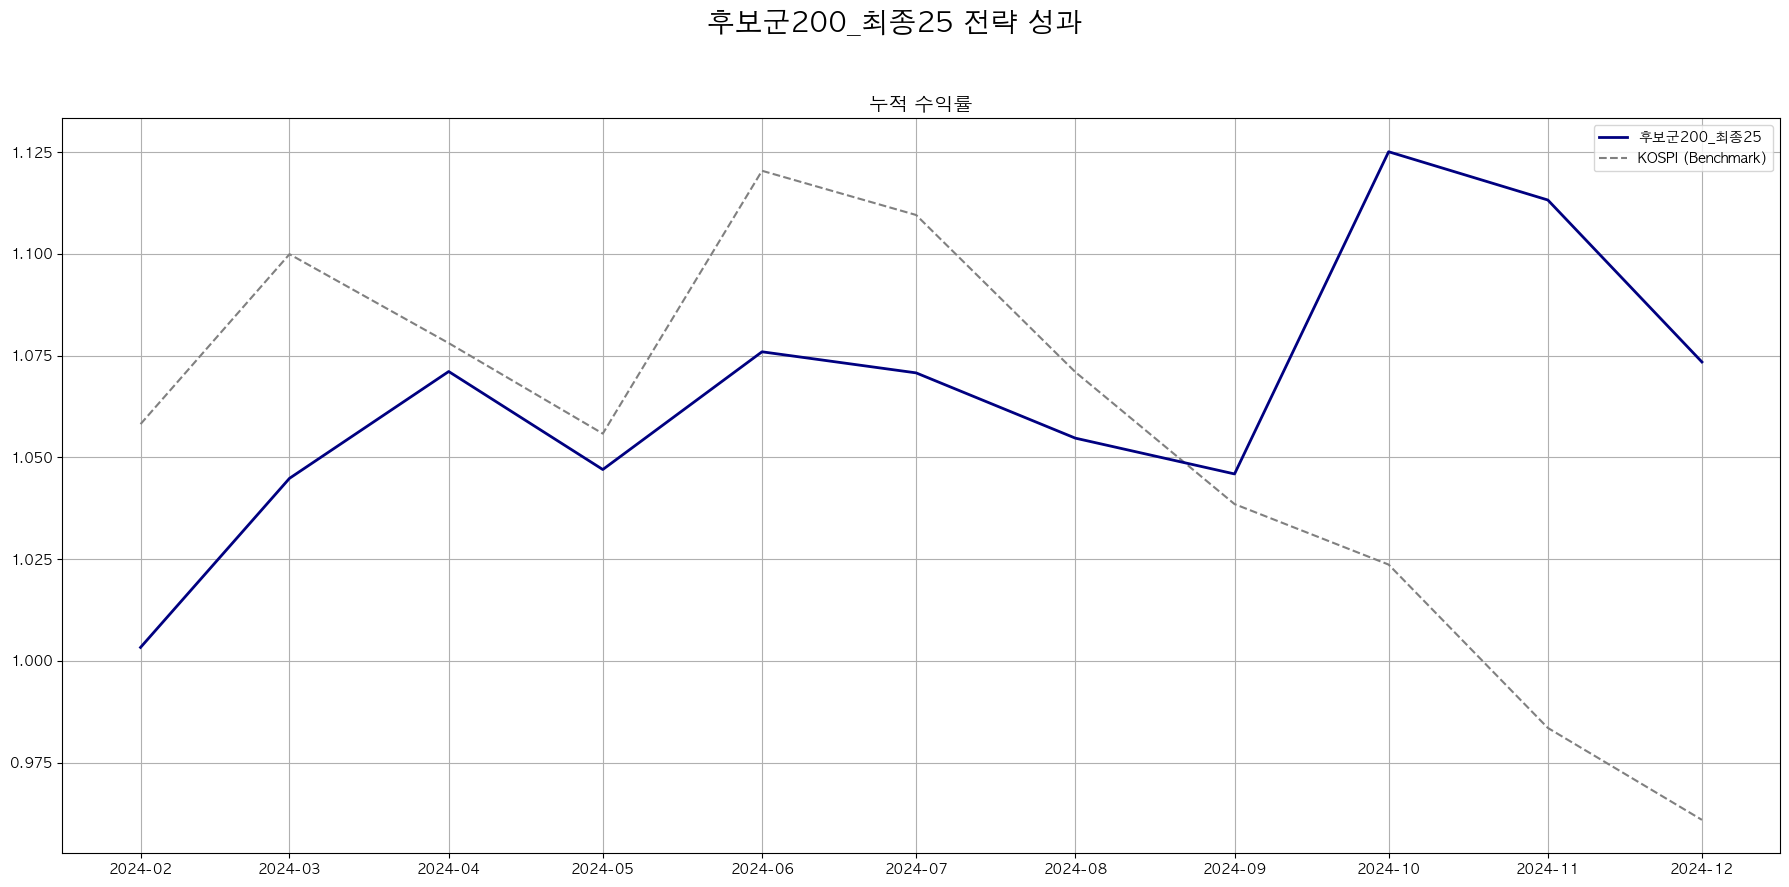

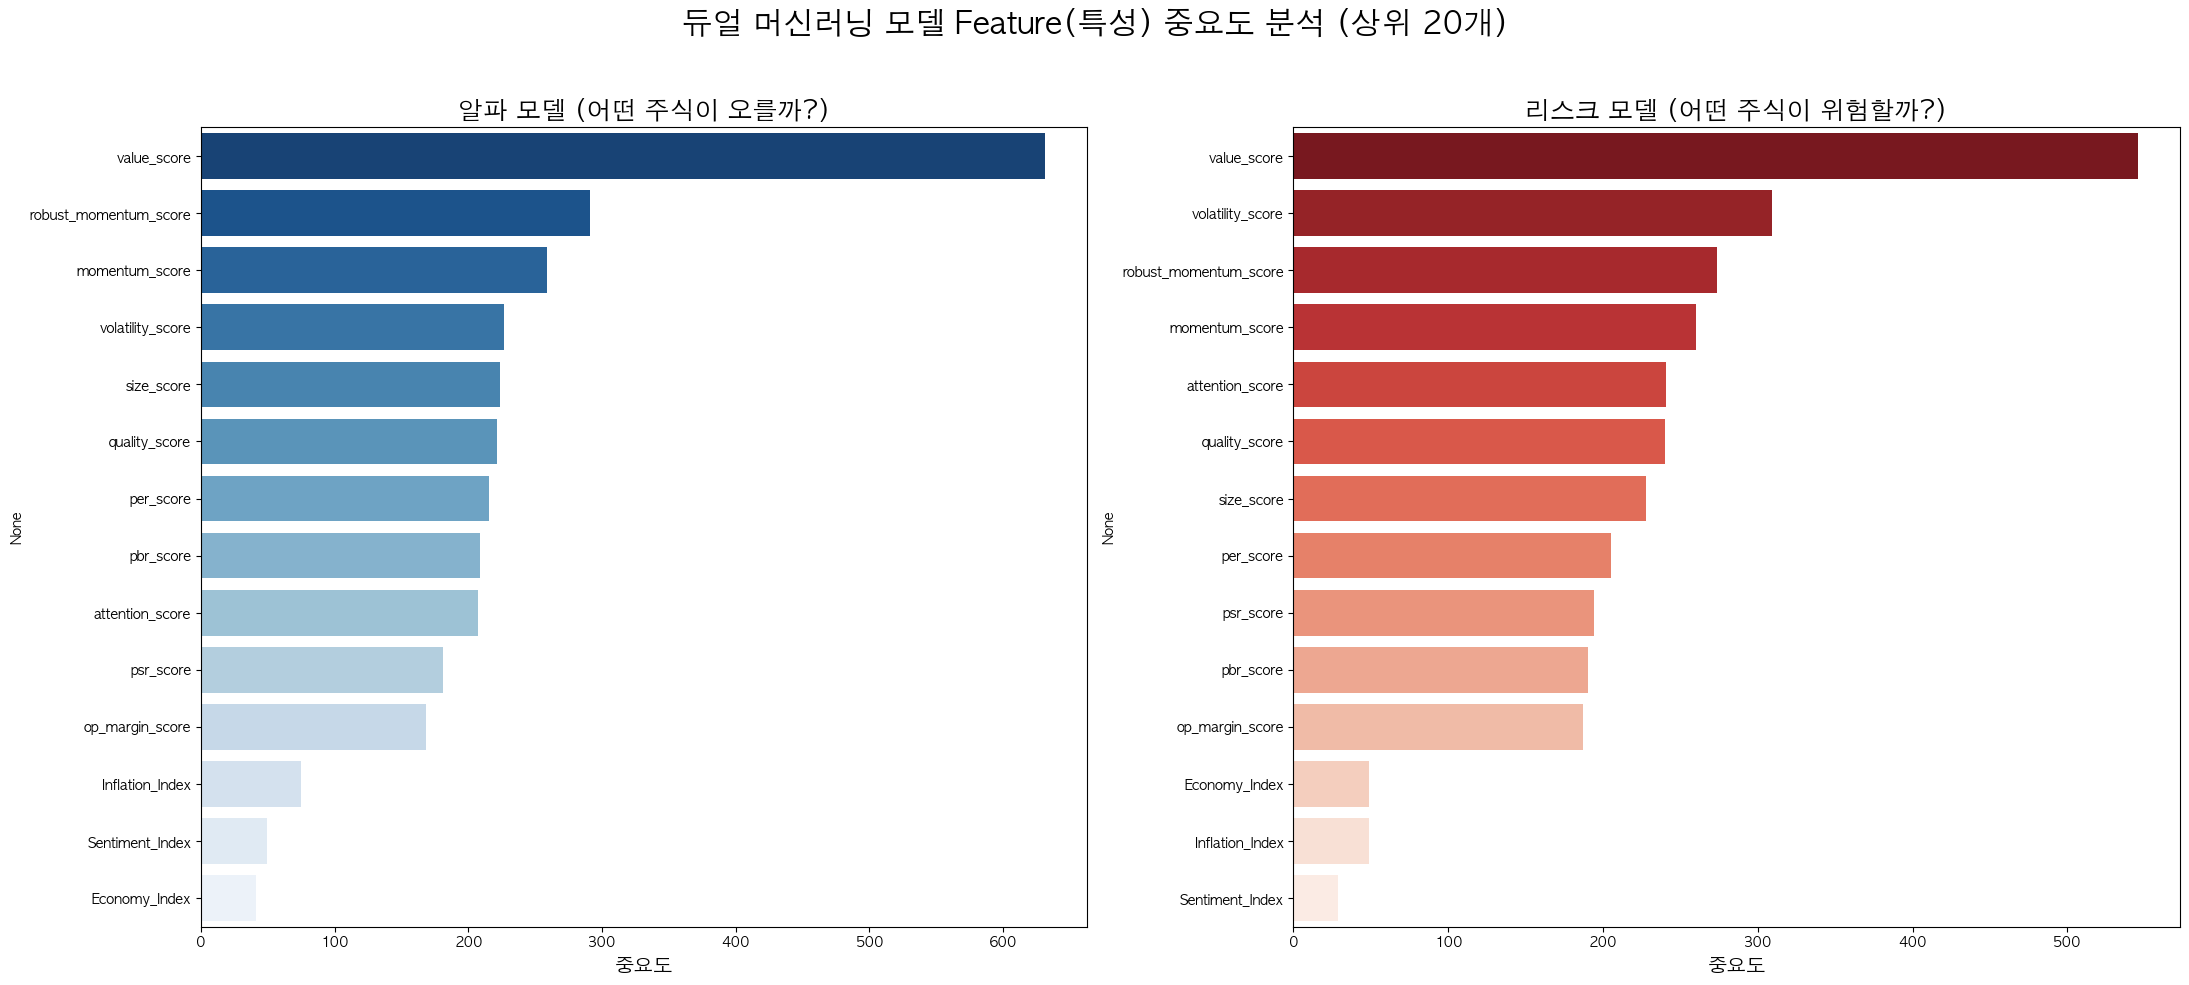

--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (Feature Importance Î∂ÑÏÑù Ìè¨Ìï®) ---
‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.
‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.
ÎìÄÏñº Î®∏Ïã†Îü¨Îãù Walk-Forward Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: 25)...


Î∞±ÌÖåÏä§Ìä∏ ÏßÑÌñâÎ•†: 12it [00:01,  6.53it/s]                       


‚úÖ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!

!!! ÏòàÏÉÅÏπò Î™ªÌïú Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: 'DualMachineLearningBacktester' object has no attribute 'print_performance_summary' !!!


In [9]:
# ÌååÏùº Ïù¥Î¶Ñ: 02_run_backtest_with_feature_importance.py
# Ïó≠Ìï†: ÏµúÏ¢Ö ÎìÄÏñº ML Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌïòÍ≥†, Ï∂îÍ∞ÄÏ†ÅÏúºÎ°ú
#       ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïù¥ Ïñ¥Îñ§ FeatureÎ•º Ï§ëÏöîÌïòÍ≤å ÏÉùÍ∞ÅÌñàÎäîÏßÄ Î∂ÑÏÑùÌïòÍ≥† ÏãúÍ∞ÅÌôî.
# ÏàòÏ†ï ÏÇ¨Ìï≠: Í∑∏Î¶¨Îìú ÏÑúÏπò ÏµúÏ†Å Ï°∞Ìï©(ÌõÑÎ≥¥Íµ∞ 200, ÏµúÏ¢Ö 25) Î∞òÏòÅ

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import os
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings
import seaborn as sns


warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# --- Matplotlib ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï ---
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        print("ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ïÏóê Ïã§Ìå®ÌñàÏäµÎãàÎã§. Í∏∞Î≥∏ Ìè∞Ìä∏Î°ú ÏÑ§Ï†ïÎê©ÎãàÎã§.")
plt.rcParams['axes.unicode_minus'] = False

# --- Ìó¨Ìçº Ìï®Ïàò ---
def get_kospi_data_for_caching(start_date, end_date):
    print("KOSPI Î≤§ÏπòÎßàÌÅ¨ Îç∞Ïù¥ÌÑ∞Î•º Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§..."); safe_end_date = pd.to_datetime(end_date) + MonthEnd(0)
    kospi_daily = fdr.DataReader('KS11', start=start_date, end=safe_end_date)
    kospi_monthly_close = kospi_daily['Close'].resample('ME').last()
    kospi_monthly_returns = kospi_monthly_close.pct_change().fillna(0)
    kospi_df_monthly = pd.DataFrame({'ÏàòÏùµÎ•†': kospi_monthly_returns}).reset_index()
    kospi_df_monthly.rename(columns={'Date': 'Í∏∞Ï§ÄÏõî'}, inplace=True)
    kospi_df_monthly['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(kospi_df_monthly['Í∏∞Ï§ÄÏõî']).dt.to_period('M').dt.to_timestamp()
    print("‚úÖ KOSPI Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ ÏôÑÎ£å!"); return kospi_df_monthly

def calculate_performance_metrics(returns_series):
    if returns_series.empty or len(returns_series) < 2: return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    total_months = len(returns_series); cum_returns = (1 + returns_series).cumprod(); cagr = cum_returns.iloc[-1] ** (12 / total_months) - 1; peak = cum_returns.expanding(min_periods=1).max(); mdd = ((cum_returns / peak) - 1).min(); volatility = returns_series.std() * np.sqrt(12); sharpe = cagr / volatility if volatility != 0 else 0; return {'CAGR': cagr, 'MDD': mdd, 'Volatility': volatility, 'Sharpe Ratio': sharpe}

# --- ÏµúÏ¢Ö Î∞±ÌÖåÏä§ÌÑ∞ ÌÅ¥ÎûòÏä§ ---
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost
        # ÌäπÏÑ± Ï§ëÏöîÎèÑÎ•º Ï†ÄÏû•ÌïòÍ∏∞ ÏúÑÌïú Î¶¨Ïä§Ìä∏ Ï¥àÍ∏∞Ìôî
        self.alpha_feature_importances = []
        self.risk_feature_importances = []
        self.feature_names = []

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        print(f"ÎìÄÏñº Î®∏Ïã†Îü¨Îãù Walk-Forward Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: {self.top_n})...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['Í∏∞Ï§ÄÏõî'].unique())
        monthly_returns = []
        
        current_train_end_idx = train_months
        # tqdmÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÏßÑÌñâ ÏÉÅÌô© ÌëúÏãú
        with tqdm(total=len(unique_dates) - train_months, desc="Î∞±ÌÖåÏä§Ìä∏ ÏßÑÌñâÎ•†") as pbar:
            while current_train_end_idx < len(unique_dates):
                train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
                test_start_idx = current_train_end_idx; test_end_idx = min(test_start_idx + test_months, len(unique_dates)); test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
                if test_start > test_end: break
                
                train_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)]
                self.feature_names = [col for col in dataset.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]
                X_train, y_alpha_train, y_risk_train = train_data[self.feature_names], train_data['y_alpha'], train_data['y_risk']
                
                # --- Î™®Îç∏ ÌïôÏäµ Î∞è ÌäπÏÑ± Ï§ëÏöîÎèÑ Ï†ÄÏû• ---
                alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
                self.alpha_feature_importances.append(alpha_model.feature_importances_)
                
                risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)
                self.risk_feature_importances.append(risk_model.feature_importances_)

                # --- ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ ÏòàÏ∏° ---
                # ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ Ï†ÑÏ≤¥Ïóê ÎåÄÌï¥ Ìïú Î≤àÏóê ÏòàÏ∏° ÏàòÌñâ
                test_period_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(test_start, test_end)].copy()
                if not test_period_data.empty:
                    X_test = test_period_data[self.feature_names]
                    test_period_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                    test_period_data['risk_score'] = risk_model.predict_proba(X_test)[:, 1]

                for date in pd.date_range(test_start, test_end, freq='MS'):
                    current_month_pred = test_period_data[test_period_data['Í∏∞Ï§ÄÏõî'] == date]
                    if current_month_pred.empty: continue
                    
                    # ### ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ ###: 1Ï∞® ÌõÑÎ≥¥Íµ∞ÏùÑ 200Í∞úÎ°ú Í≥†Ï†ï
                    candidate_stocks = current_month_pred.nlargest(200, 'alpha_score')
                    final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist()
                    
                    next_month_date = date + pd.DateOffset(months=1)
                    next_month_data_orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month_date]
                    next_month_returns = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(final_portfolio_stocks)]
                    monthly_return = (next_month_returns['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                    monthly_returns.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': monthly_return})
                
                pbar.update(test_months)
                current_train_end_idx += test_months
        
        print("\n‚úÖ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!");
        self.returns_df = pd.DataFrame(monthly_returns).set_index('Í∏∞Ï§ÄÏõî')
        performance = calculate_performance_metrics(self.returns_df['ÏàòÏùµÎ•†'].dropna())
        self.performance_summary = pd.DataFrame(performance, index=[f'ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö{self.top_n}']).T
        self.print_performance_summary()
    
    def display_feature_importances(self):
        """ÏïåÌåå/Î¶¨Ïä§ÌÅ¨ Î™®Îç∏Ïùò ÌèâÍ∑† ÌäπÏÑ± Ï§ëÏöîÎèÑÎ•º Í≥ÑÏÇ∞ÌïòÍ≥† ÏãúÍ∞ÅÌôîÌï©ÎãàÎã§."""
        if not self.alpha_feature_importances or not self.risk_feature_importances:
            print("ÌäπÏÑ± Ï§ëÏöîÎèÑ Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return

        # ÏïåÌåå Î™®Îç∏ Ï§ëÏöîÎèÑ (ÏÉÅÏúÑ 20Í∞ú)
        alpha_imp = pd.DataFrame(self.alpha_feature_importances, columns=self.feature_names).mean().nlargest(20)
        # Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ Ï§ëÏöîÎèÑ (ÏÉÅÏúÑ 20Í∞ú)
        risk_imp = pd.DataFrame(self.risk_feature_importances, columns=self.feature_names).mean().nlargest(20)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 10))
        fig.suptitle('ÎìÄÏñº Î®∏Ïã†Îü¨Îãù Î™®Îç∏ Feature(ÌäπÏÑ±) Ï§ëÏöîÎèÑ Î∂ÑÏÑù (ÏÉÅÏúÑ 20Í∞ú)', fontsize=22)

        sns.barplot(x=alpha_imp.values, y=alpha_imp.index, ax=ax1, palette='Blues_r')
        ax1.set_title('ÏïåÌåå Î™®Îç∏ (Ïñ¥Îñ§ Ï£ºÏãùÏù¥ Ïò§Î•ºÍπå?)', fontsize=18)
        ax1.set_xlabel('Ï§ëÏöîÎèÑ', fontsize=14)

        sns.barplot(x=risk_imp.values, y=risk_imp.index, ax=ax2, palette='Reds_r')
        ax2.set_title('Î¶¨Ïä§ÌÅ¨ Î™®Îç∏ (Ïñ¥Îñ§ Ï£ºÏãùÏù¥ ÏúÑÌóòÌï†Íπå?)', fontsize=18)
        ax2.set_xlabel('Ï§ëÏöîÎèÑ', fontsize=14)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    def print_performance_summary(self):
        print("\n" + "="*60); print(" " * 12 + f"- {self.performance_summary.columns[0]} Ï†ÑÎûµ ÏµúÏ¢Ö ÏÑ±Í≥º -"); print("="*60)
        summary_df = self.performance_summary.copy();
        summary_df.iloc[0,0] = f"{summary_df.iloc[0,0]:.2%}" # CAGR
        summary_df.iloc[1,0] = f"{summary_df.iloc[1,0]:.2%}" # MDD
        summary_df.iloc[2,0] = f"{summary_df.iloc[2,0]:.2%}" # Volatility
        summary_df.iloc[3,0] = f"{summary_df.iloc[3,0]:.2f}" # Sharpe Ratio
        print(summary_df); print("="*60)

    def plot_results(self, kospi_df):
        if self.returns_df is None or self.returns_df.empty: return
        fig, ax1 = plt.subplots(1, 1, figsize=(18, 9)); fig.suptitle(f'{self.performance_summary.columns[0]} Ï†ÑÎûµ ÏÑ±Í≥º', fontsize=20)
        cum_returns = (1 + self.returns_df['ÏàòÏùµÎ•†'].fillna(0)).cumprod()
        kospi_returns_aligned = kospi_df.set_index('Í∏∞Ï§ÄÏõî').loc[cum_returns.index]
        cum_returns_kospi = (1 + kospi_returns_aligned['ÏàòÏùµÎ•†']).cumprod()
        ax1.plot(cum_returns.index, cum_returns, label=self.performance_summary.columns[0], color='navy', lw=2, zorder=5)
        ax1.plot(cum_returns_kospi.index, cum_returns_kospi, label='KOSPI (Benchmark)', color='grey', ls='--', zorder=4)
        ax1.set_title('ÎàÑÏ†Å ÏàòÏùµÎ•†', fontsize=14); ax1.legend(); ax1.grid(True); plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# --- Î©îÏù∏ Ïã§Ìñâ Î∏îÎ°ù ---
if __name__ == '__main__':
    print("--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (Feature Importance Î∂ÑÏÑù Ìè¨Ìï®) ---")
    try:
        # 1. Îç∞Ïù¥ÌÑ∞ Î°úÎìú
        ml_dataset = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_original = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        
        kospi_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
            print("‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
        except FileNotFoundError:
            print("‚ö†Ô∏è Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏÉàÎ°ú Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§.")
            start_date, end_date = df_original['Í∏∞Ï§ÄÏõî'].min(), df_original['Í∏∞Ï§ÄÏõî'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)
        
        print("‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")

        # 2. Î∞±ÌÖåÏä§ÌÑ∞ Ïã§Ìñâ
        train_months = 36
        
        # ### ÏàòÏ†ïÎêú Î∂ÄÎ∂Ñ ###: ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© ÏàòÎ•º 25Í∞úÎ°ú ÏÑ§Ï†ï
        ml_backtester = DualMachineLearningBacktester(
            ml_dataset=ml_dataset, 
            df_original=df_original, 
            top_n=25
        )
        ml_backtester.run_walk_forward_backtest(train_months=train_months, test_months=6)
        
        # 3. Í≤∞Í≥º ÏãúÍ∞ÅÌôî
        ml_backtester.plot_results(kospi_df)
        
        # 4. ÌäπÏÑ± Ï§ëÏöîÎèÑ Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî
        ml_backtester.display_feature_importances()

    except FileNotFoundError as e:
        print(f"\n!!! Ïò§Î•ò: {e} !!!"); print("Î®ºÏ†Ä '01_build_ultimate_dataset.py'Î•º Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")
    except Exception as e:
        print(f"\n!!! ÏòàÏÉÅÏπò Î™ªÌïú Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: {e} !!!")
# ... Í∏∞Ï°¥ import Î∞è ÏÑ§Ï†ï ÏÉùÎûµ ...
    def print_performance_summary(self):
        print("\n" + "="*80)
        print("üìà Ï†ÑÎûµ ÏÑ±Í≥º ÏöîÏïΩ (Performance Summary)")
        print("="*80)
        print(self.performance_summary.round(4))
        print("="*80 + "\n")
class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=20, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost
        self.alpha_feature_importances = []
        self.risk_feature_importances = []
        self.feature_names = []
        self.final_selected_stocks = {}  # ‚úÖ ÏõîÎ≥Ñ Ï¢ÖÎ™© Ï†ÄÏû•Ïö©

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        print(f"ÎìÄÏñº Î®∏Ïã†Îü¨Îãù Walk-Forward Î∞±ÌÖåÏä§Ìä∏Î•º Ïã§ÌñâÌï©ÎãàÎã§ (ÏµúÏ¢Ö Ï¢ÖÎ™© Ïàò: {self.top_n})...");
        dataset = self.ml_dataset.copy(); unique_dates = sorted(dataset['Í∏∞Ï§ÄÏõî'].unique())
        monthly_returns = []

        current_train_end_idx = train_months
        with tqdm(total=len(unique_dates) - train_months, desc="Î∞±ÌÖåÏä§Ìä∏ ÏßÑÌñâÎ•†") as pbar:
            while current_train_end_idx < len(unique_dates):
                train_start, train_end = unique_dates[0], unique_dates[current_train_end_idx - 1]
                test_start_idx = current_train_end_idx
                test_end_idx = min(test_start_idx + test_months, len(unique_dates))
                test_start, test_end = unique_dates[test_start_idx], unique_dates[test_end_idx - 1]
                if test_start > test_end: break

                train_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)]
                self.feature_names = [col for col in dataset.columns if col not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']]
                X_train, y_alpha_train, y_risk_train = train_data[self.feature_names], train_data['y_alpha'], train_data['y_risk']

                alpha_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); alpha_model.fit(X_train, y_alpha_train)
                self.alpha_feature_importances.append(alpha_model.feature_importances_)
                risk_model = lgb.LGBMClassifier(random_state=42, verbosity=-1); risk_model.fit(X_train, y_risk_train)
                self.risk_feature_importances.append(risk_model.feature_importances_)

                test_period_data = dataset[dataset['Í∏∞Ï§ÄÏõî'].between(test_start, test_end)].copy()
                if not test_period_data.empty:
                    X_test = test_period_data[self.feature_names]
                    test_period_data['alpha_score'] = alpha_model.predict_proba(X_test)[:, 1]
                    test_period_data['risk_score'] = risk_model.predict_proba(X_test)[:, 1]

                for date in pd.date_range(test_start, test_end, freq='MS'):
                    current_month_pred = test_period_data[test_period_data['Í∏∞Ï§ÄÏõî'] == date]
                    if current_month_pred.empty: continue

                    candidate_stocks = current_month_pred.nlargest(200, 'alpha_score')
                    final_portfolio_stocks = candidate_stocks.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].tolist()

                    # ‚úÖ ÏõîÎ≥Ñ Ï¢ÖÎ™© Ï†ÄÏû•
                    self.final_selected_stocks[date.strftime("%Y-%m")] = final_portfolio_stocks

                    next_month_date = date + pd.DateOffset(months=1)
                    next_month_data_orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month_date]
                    next_month_returns = next_month_data_orig[next_month_data_orig['Ï¢ÖÎ™©ÏΩîÎìú'].isin(final_portfolio_stocks)]
                    monthly_return = (next_month_returns['1Í∞úÏõîÏàòÏùµÎ•†'].mean() - self.cost) if not next_month_returns.empty else -self.cost
                    monthly_returns.append({'Í∏∞Ï§ÄÏõî': next_month_date, 'ÏàòÏùµÎ•†': monthly_return})

                pbar.update(test_months)
                current_train_end_idx += test_months

        print("\n‚úÖ Î∞±ÌÖåÏä§Ìä∏ ÏôÑÎ£å!");
        self.returns_df = pd.DataFrame(monthly_returns).set_index('Í∏∞Ï§ÄÏõî')
        performance = calculate_performance_metrics(self.returns_df['ÏàòÏùµÎ•†'].dropna())
        self.performance_summary = pd.DataFrame(performance, index=[f'ÌõÑÎ≥¥Íµ∞200_ÏµúÏ¢Ö{self.top_n}']).T
        self.print_performance_summary()
        
        # ‚úÖ Ï¢ÖÎ™© Í≤∞Í≥º CSV Ï†ÄÏû•
        selected_df = pd.DataFrame([
            {'Í∏∞Ï§ÄÏõî': month, 'Ï¢ÖÎ™©ÏΩîÎìú': code}
            for month, codes in self.final_selected_stocks.items()
            for code in codes
        ])
        selected_df.to_csv("final_selected_stocks.csv", index=False, encoding='utf-8-sig')
        print("üìÅ ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™©ÏùÑ 'final_selected_stocks.csv'Î°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§.")

    # ÎÇòÎ®∏ÏßÄ print_performance_summary, display_feature_importances, plot_results Ìï®ÏàòÎäî Í∑∏ÎåÄÎ°ú Ïú†ÏßÄ

# --- Î©îÏù∏ Ïã§Ìñâ Î∏îÎ°ù ---
if __name__ == '__main__':
    print("--- ÏµúÏ¢Ö Î®∏Ïã†Îü¨Îãù Î∞±ÌÖåÏä§ÌåÖ Ïã§Ìñâ ÏãúÏûë (Feature Importance Î∂ÑÏÑù Ìè¨Ìï®) ---")
    try:
        ml_dataset = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])
        df_original = pd.read_csv("/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv", parse_dates=['Í∏∞Ï§ÄÏõî'])

        kospi_filepath = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
        try:
            kospi_df = pd.read_csv(kospi_filepath, parse_dates=['Í∏∞Ï§ÄÏõî'])
            print("‚úÖ Í∏∞Ï°¥Ïóê Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Î•º Î∂àÎü¨ÏôîÏäµÎãàÎã§.")
        except FileNotFoundError:
            print("‚ö†Ô∏è Ï†ÄÏû•Îêú KOSPI Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏñ¥ ÏÉàÎ°ú Îã§Ïö¥Î°úÎìúÌï©ÎãàÎã§.")
            start_date, end_date = df_original['Í∏∞Ï§ÄÏõî'].min(), df_original['Í∏∞Ï§ÄÏõî'].max()
            kospi_df = get_kospi_data_for_caching(start_date, end_date)
            kospi_df.to_csv(kospi_filepath, index=False)

        print("‚úÖ Î™®Îì† Ï§ÄÎπÑÎêú Îç∞Ïù¥ÌÑ∞Î•º ÏÑ±Í≥µÏ†ÅÏúºÎ°ú Î∂àÎü¨ÏôîÏäµÎãàÎã§.")

        ml_backtester = DualMachineLearningBacktester(
            ml_dataset=ml_dataset,
            df_original=df_original,
            top_n=25
        )
        ml_backtester.run_walk_forward_backtest(train_months=36, test_months=6)
        ml_backtester.plot_results(kospi_df)
        ml_backtester.display_feature_importances()

    except FileNotFoundError as e:
        print(f"\n!!! Ïò§Î•ò: {e} !!!")
        print("Î®ºÏ†Ä '01_build_ultimate_dataset.py'Î•º Ïã§ÌñâÌïòÏó¨ Îç∞Ïù¥ÌÑ∞ ÌååÏùºÏùÑ ÏÉùÏÑ±Ìï¥Ï£ºÏÑ∏Ïöî.")
    except Exception as e:
        print(f"\n!!! ÏòàÏÉÅÏπò Î™ªÌïú Ïò§Î•òÍ∞Ä Î∞úÏÉùÌñàÏäµÎãàÎã§: {e} !!!")

Î∞±ÌÖåÏä§Ìä∏: 12it [00:01,  6.27it/s]                       


üìÅ Ï¢ÖÎ™©+Ï¢ÖÎ™©Î™ÖÏùÑ 'final_selected_with_names.csv'Î°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§.

=== ÏõîÎ≥Ñ ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© ÏΩîÎìú ===
2024-01: 13120, 16090, 24070, 12630, 38500, 192400, 2600, 2810, 17000, 16450, 19440, 41650, 4980, 36000, 2150, 79430, 225190, 1420, 108670, 3080, 88790, 161390, 43370, 650, 136490
2024-02: 16920, 35000, 1420, 3240, 1430, 294870, 120, 264660, 272210, 198080, 88910, 16450, 19540, 43260, 161390, 78150, 2350, 126640, 14530, 36200, 12860, 1250, 35150, 38110, 100
2024-03: 16450, 267250, 120, 10950, 86280, 7980, 16380, 103590, 19540, 3240, 12330, 161390, 111770, 307950, 15890, 4000, 5850, 84730, 78150, 64350, 12860, 1430, 7210, 78930, 15750
2024-04: 32640, 54800, 5990, 34590, 4650, 29960, 6390, 23150, 32280, 192390, 54410, 92230, 24070, 92130, 11760, 70960, 60380, 21650, 10130, 48830, 79650, 1120, 3490, 86280, 8470
2024-05: 2690, 12160, 12620, 129260, 14710, 100250, 17000, 9770, 25750, 2070, 1520, 33920, 13120, 11370, 16920, 155660, 143210, 14440, 192390, 37400,

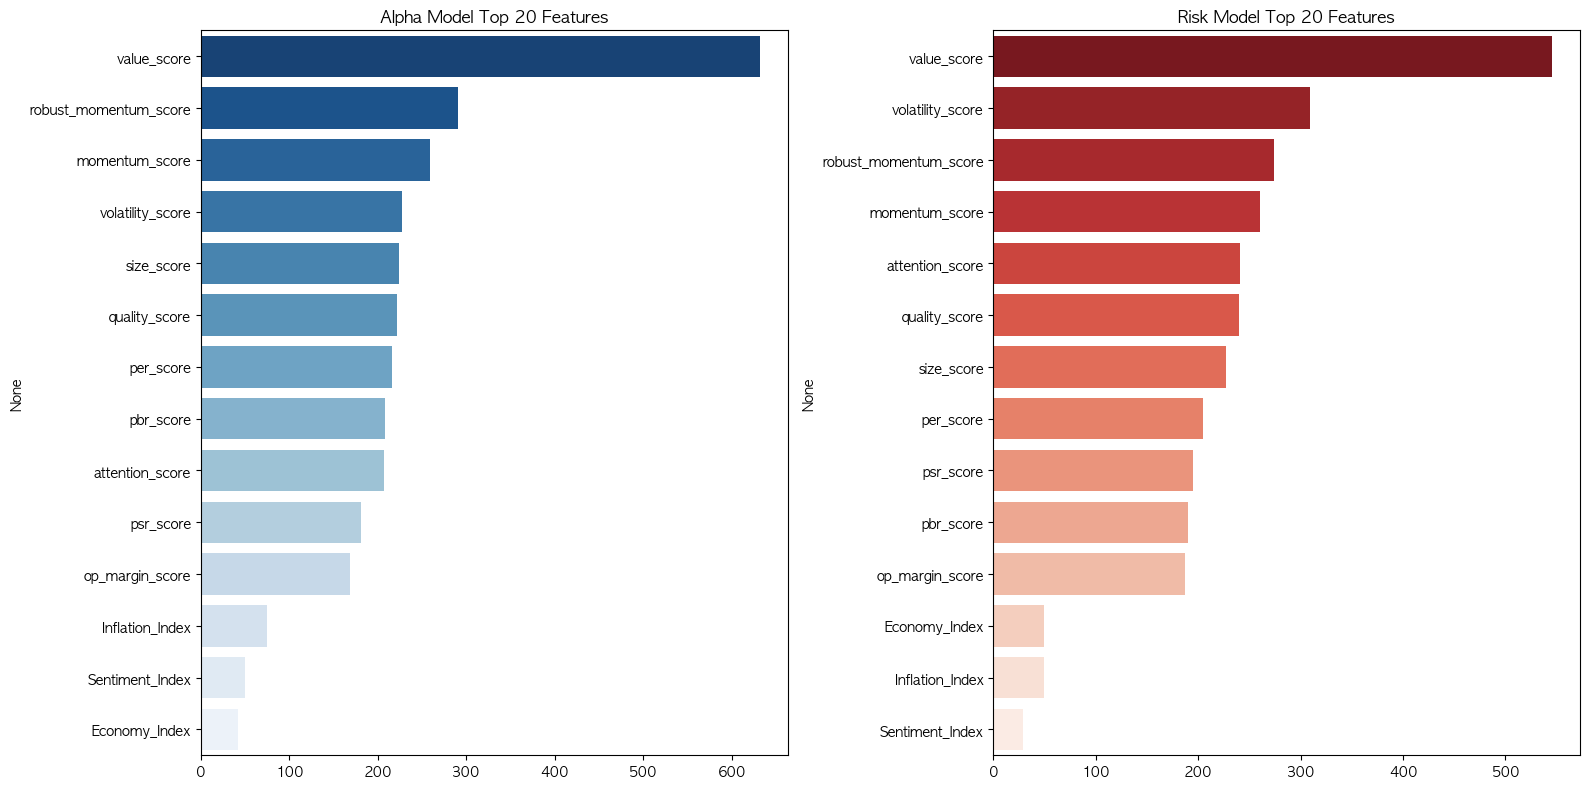


=== Performance Comparison ===
             CAGR     MDD  Volatility  Sharpe Ratio
Model      0.0804 -0.0459      0.1124        0.7148
Benchmark -0.0426 -0.1424      0.1291       -0.3296


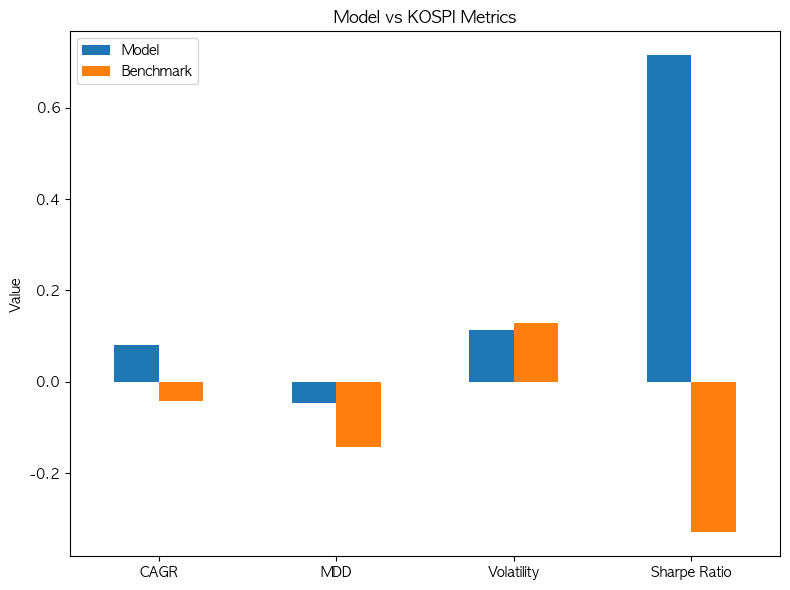

In [10]:
# ÌååÏùº Ïù¥Î¶Ñ: 02_run_backtest_with_feature_importance_and_print.py
# Ïó≠Ìï†: ÎìÄÏñº ML Î∞±ÌÖåÏä§Ìä∏ Ïã§Ìñâ, Feature Ï§ëÏöîÎèÑ ÏãúÍ∞ÅÌôî, Î™®Îç∏ vs Î≤§ÏπòÎßàÌÅ¨ ÎπÑÍµê,
#       ÏµúÏ¢Ö ÏÑ†Ï†ï Ï¢ÖÎ™© ÏΩîÎìú¬∑Ï¢ÖÎ™©Î™Ö Ï∂úÎ†• (Ï¢ÖÎ™©Î™Ö Îß§Ìïë Ïò§Î•ò ÏàòÏ†ï)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import lightgbm as lgb
import FinanceDataReader as fdr
from pandas.tseries.offsets import MonthEnd
import warnings
import seaborn as sns

warnings.filterwarnings('ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
try:
    plt.rc('font', family='AppleGothic')
except:
    try:
        plt.rc('font', family='Malgun Gothic')
    except:
        pass
plt.rcParams['axes.unicode_minus'] = False


def get_kospi_data_for_caching(start_date, end_date):
    safe_end = pd.to_datetime(end_date) + MonthEnd(0)
    df = fdr.DataReader('KS11', start=start_date, end=safe_end)
    monthly_close = df['Close'].resample('ME').last()
    returns = monthly_close.pct_change().fillna(0)
    kospi = returns.to_frame(name='ÏàòÏùµÎ•†').reset_index().rename(columns={'Date': 'Í∏∞Ï§ÄÏõî'})
    kospi['Í∏∞Ï§ÄÏõî'] = pd.to_datetime(kospi['Í∏∞Ï§ÄÏõî']).dt.to_period('M').dt.to_timestamp()
    return kospi


def calculate_performance_metrics(returns):
    if returns.empty or len(returns) < 2:
        return {'CAGR': 0, 'MDD': 0, 'Volatility': 0, 'Sharpe Ratio': 0}
    cum = (1 + returns).cumprod()
    total = len(returns)
    cagr = cum.iloc[-1] ** (12 / total) - 1
    peak = cum.cummax()
    mdd = (cum / peak - 1).min()
    vol = returns.std() * np.sqrt(12)
    sharpe = cagr / vol if vol != 0 else 0
    return {'CAGR': cagr, 'MDD': mdd, 'Volatility': vol, 'Sharpe Ratio': sharpe}


class DualMachineLearningBacktester:
    def __init__(self, ml_dataset, df_original, top_n=25, cost=0.003):
        self.ml_dataset = ml_dataset
        self.df_original = df_original
        self.top_n = top_n
        self.cost = cost
        self.alpha_imps = []
        self.risk_imps = []
        self.feature_names = []
        self.selected = {}           # ÏõîÎ≥Ñ ÏµúÏ¢Ö Ï¢ÖÎ™©ÏΩîÎìú Ï†ÄÏû•
        self.code2name = {}         # Ï¢ÖÎ™©Î™Ö Îß§Ìïë Ï†ÄÏû•
        self.returns_df = None
        self.performance = {}

    def run_walk_forward_backtest(self, train_months=36, test_months=6):
        dates = sorted(self.ml_dataset['Í∏∞Ï§ÄÏõî'].unique())
        idx = train_months
        returns = []

        # ÏÇ¨Ïö©Ìï† ÌîºÏ≤òÎ™Ö Î¶¨Ïä§Ìä∏
        self.feature_names = [
            c for c in self.ml_dataset.columns
            if c not in ['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'y_alpha', 'y_risk']
        ]

        pbar = tqdm(total=len(dates) - train_months, desc="Î∞±ÌÖåÏä§Ìä∏")
        while idx < len(dates):
            train_start, train_end = dates[0], dates[idx - 1]
            test_start, test_end = dates[idx], dates[min(idx + test_months - 1, len(dates) - 1)]

            train = self.ml_dataset[
                self.ml_dataset['Í∏∞Ï§ÄÏõî'].between(train_start, train_end)
            ]
            X_tr = train[self.feature_names]
            y_a = train['y_alpha']
            y_r = train['y_risk']

            # Alpha Î™®Îç∏ ÌïôÏäµ
            model_a = lgb.LGBMClassifier(random_state=42)
            model_a.fit(X_tr, y_a)
            self.alpha_imps.append(model_a.feature_importances_)

            # Risk Î™®Îç∏ ÌïôÏäµ
            model_r = lgb.LGBMClassifier(random_state=42)
            model_r.fit(X_tr, y_r)
            self.risk_imps.append(model_r.feature_importances_)

            # ÌÖåÏä§Ìä∏ Í∏∞Í∞Ñ Îç∞Ïù¥ÌÑ∞
            test = self.ml_dataset[
                self.ml_dataset['Í∏∞Ï§ÄÏõî'].between(test_start, test_end)
            ].copy()
            if not test.empty:
                X_te = test[self.feature_names]
                test['alpha_score'] = model_a.predict_proba(X_te)[:, 1]
                test['risk_score'] = model_r.predict_proba(X_te)[:, 1]

            # ÏõîÎ≥Ñ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ÏÑ†Ï†ï Î∞è ÏàòÏùµÎ•† Í≥ÑÏÇ∞
            for month in pd.date_range(test_start, test_end, freq='MS'):
                tm = test[test['Í∏∞Ï§ÄÏõî'] == month]
                if tm.empty:
                    continue

                cand = tm.nlargest(200, 'alpha_score')
                final = cand.nsmallest(self.top_n, 'risk_score')['Ï¢ÖÎ™©ÏΩîÎìú'].astype(str).tolist()
                self.selected[month.strftime("%Y-%m")] = final

                next_month = month + pd.DateOffset(months=1)
                orig = self.df_original[self.df_original['Í∏∞Ï§ÄÏõî'] == next_month]
                ret = orig[orig['Ï¢ÖÎ™©ÏΩîÎìú'].astype(str).isin(final)]['1Í∞úÏõîÏàòÏùµÎ•†']
                mr = ret.mean() - self.cost if not ret.empty else -self.cost
                returns.append({'Í∏∞Ï§ÄÏõî': next_month, 'ÏàòÏùµÎ•†': mr})

            idx += test_months
            pbar.update(test_months)
        pbar.close()

        self.returns_df = pd.DataFrame(returns).set_index('Í∏∞Ï§ÄÏõî')
        self.performance = calculate_performance_metrics(self.returns_df['ÏàòÏùµÎ•†'])
        return self.performance

    def save_selected_with_names(self, output_csv="final_selected_with_names.csv"):
        # Ï¢ÖÎ™©Î™Ö Îß§Ìïë Ï§ÄÎπÑ
        if 'Ï¢ÖÎ™©Î™Ö' in self.df_original.columns:
            self.code2name = dict(
                self.df_original[['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö']].drop_duplicates().values
            )
        else:
            # FinanceDataReaderÏóêÏÑú ÏÉÅÏû•Ï¢ÖÎ™© Î¶¨Ïä§Ìä∏ Î∂àÎü¨ÏôÄÏÑú Ï≤´ Îëê Ïª¨ÎüºÏùÑ ÏΩîÎìú/Ïù¥Î¶ÑÏúºÎ°ú ÏÇ¨Ïö©
            listing = fdr.StockListing('KRX')
            cols = listing.columns.tolist()
            code_col, name_col = cols[0], cols[1]
            self.code2name = listing.set_index(code_col)[name_col].astype(str).to_dict()

        rows = []
        for month, codes in self.selected.items():
            for c in codes:
                rows.append({
                    'Í∏∞Ï§ÄÏõî': month,
                    'Ï¢ÖÎ™©ÏΩîÎìú': c,
                    'Ï¢ÖÎ™©Î™Ö': self.code2name.get(c, '')
                })

        pd.DataFrame(rows).to_csv(output_csv, index=False, encoding='utf-8-sig')
        print(f"üìÅ Ï¢ÖÎ™©+Ï¢ÖÎ™©Î™ÖÏùÑ '{output_csv}'Î°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§.")

    def print_selected_stocks(self):
        if not self.selected:
            print("ÏïÑÏßÅ ÏµúÏ¢Ö Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return
        print("\n=== ÏõîÎ≥Ñ ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© ÏΩîÎìú ===")
        for month, codes in self.selected.items():
            print(f"{month}: {', '.join(codes)}")
        print("==============================\n")

    def print_selected_stocks_with_names(self):
        if not self.selected or not self.code2name:
            print("Ï¢ÖÎ™©Î™Ö Îß§Ìïë ÎòêÎäî ÏÑ†Ï†ï Ï¢ÖÎ™© Îç∞Ïù¥ÌÑ∞Í∞Ä ÏóÜÏäµÎãàÎã§.")
            return
        print("\n=== ÏõîÎ≥Ñ ÏµúÏ¢Ö Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Ï¢ÖÎ™© ÏΩîÎìú + Ï¢ÖÎ™©Î™Ö ===")
        for month, codes in self.selected.items():
            lines = [
                f"{c} ({self.code2name.get(c, '')})"
                for c in codes
            ]
            print(f"{month}: {', '.join(lines)}")
        print("========================================\n")

    def display_feature_importances(self):
        alpha_imp = pd.DataFrame(self.alpha_imps, columns=self.feature_names).mean().nlargest(20)
        risk_imp  = pd.DataFrame(self.risk_imps,  columns=self.feature_names).mean().nlargest(20)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        sns.barplot(x=alpha_imp.values, y=alpha_imp.index, ax=ax1, palette='Blues_r')
        ax1.set_title('Alpha Model Top 20 Features')
        sns.barplot(x=risk_imp.values, y=risk_imp.index, ax=ax2, palette='Reds_r')
        ax2.set_title('Risk Model Top 20 Features')
        plt.tight_layout()
        plt.show()

    def compare_with_benchmark(self, kospi_df):
        bench = kospi_df.set_index('Í∏∞Ï§ÄÏõî').loc[self.returns_df.index, 'ÏàòÏùµÎ•†']
        bench_perf = calculate_performance_metrics(bench)
        df = pd.DataFrame({
            'Model': self.performance,
            'Benchmark': bench_perf
        }).T
        print("\n=== Performance Comparison ===")
        print(df.round(4))
        df.T.plot.bar(figsize=(8, 6))
        plt.title('Model vs KOSPI Metrics')
        plt.ylabel('Value')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    # 1) Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞
    ml_df = pd.read_csv(
        "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv",
        parse_dates=['Í∏∞Ï§ÄÏõî']
    )
    orig_df = pd.read_csv(
        "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv",
        parse_dates=['Í∏∞Ï§ÄÏõî']
    )

    # 2) KOSPI Î≤§ÏπòÎßàÌÅ¨ Ï§ÄÎπÑ
    kospi_path = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/kospi_monthly_returns.csv"
    try:
        kospi = pd.read_csv(kospi_path, parse_dates=['Í∏∞Ï§ÄÏõî'])
    except FileNotFoundError:
        kospi = get_kospi_data_for_caching(
            orig_df['Í∏∞Ï§ÄÏõî'].min(), orig_df['Í∏∞Ï§ÄÏõî'].max()
        )
        kospi.to_csv(kospi_path, index=False)

    # 3) Î∞±ÌÖåÏä§ÌÑ∞ Ïã§Ìñâ
    backtester = DualMachineLearningBacktester(ml_df, orig_df, top_n=25)
    perf = backtester.run_walk_forward_backtest(train_months=36, test_months=6)

    # 4) Ï¢ÖÎ™©Î™Ö Ï†ÄÏû• Î∞è Ï∂úÎ†•
    backtester.save_selected_with_names("final_selected_with_names.csv")
    backtester.print_selected_stocks()
    backtester.print_selected_stocks_with_names()

    # 5) Feature Ï§ëÏöîÎèÑ Î∞è ÏÑ±Í≥º ÎπÑÍµê
    backtester.display_feature_importances()
    backtester.compare_with_benchmark(kospi)

In [16]:
import pandas as pd

# 1) ÏµúÏ¢Ö ÏÑ†Ï†ï Ï¢ÖÎ™© CSV Î∂àÎü¨Ïò§Í∏∞
sel = pd.read_csv(
    "final_selected_with_names.csv",
    dtype={"Ï¢ÖÎ™©ÏΩîÎìú": str},
    parse_dates=["Í∏∞Ï§ÄÏõî"]
)
sel['Ï¢ÖÎ™©ÏΩîÎìú'] = sel['Ï¢ÖÎ™©ÏΩîÎìú'].str.zfill(6)

# 2) ÏõêÎ≥∏ stock_0.3ver.csv Î∂àÎü¨Ïò§Í∏∞
orig = pd.read_csv(
    "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv",
    dtype={"Ï¢ÖÎ™©ÏΩîÎìú": str},
    parse_dates=["Í∏∞Ï§ÄÏõî"]
)
orig['Ï¢ÖÎ™©ÏΩîÎìú'] = orig['Ï¢ÖÎ™©ÏΩîÎìú'].str.zfill(6)


# 3) Ï¢ÖÎ™©Î™Ö Ïª¨Îüº ÏûêÎèô ÏÑ†ÌÉù
possible_name_cols = ['Ï¢ÖÎ™©Î™Ö', 'ÌöåÏÇ¨Î™Ö', 'Í∏∞ÏóÖÎ™Ö', 'Name']
name_col = next((c for c in possible_name_cols if c in orig.columns), None)
if name_col is None:
    raise KeyError("ÏõêÎ≥∏ ÌååÏùºÏóê Ï¢ÖÎ™©Î™Ö Ïª¨ÎüºÏùÑ Ï∞æÏùÑ Ïàò ÏóÜÏäµÎãàÎã§.")

# 4) ÏΩîÎìú‚ÜíÏù¥Î¶Ñ Îß§Ìïë ÏÇ¨Ï†Ñ ÏÉùÏÑ±
code2name = (
    orig[['Ï¢ÖÎ™©ÏΩîÎìú', name_col]]
    .drop_duplicates()
    .set_index('Ï¢ÖÎ™©ÏΩîÎìú')[name_col]
    .to_dict()
)

# 5) Ï¢ÖÎ™©Î™Ö Îß§Ìïë
sel['Ï¢ÖÎ™©Î™Ö'] = sel['Ï¢ÖÎ™©ÏΩîÎìú'].map(code2name)

# 6) ÏõîÎ≥Ñ ÏÉÅÏúÑ 25Í∞ú Ï¢ÖÎ™©Îßå Ï∂îÏ∂ú
top25_each_month = sel.groupby('Í∏∞Ï§ÄÏõî').head(25)

# 7) ÏΩòÏÜî Ï∂úÎ†•: ÏõîÎ≥Ñ Top25
print("\n=== ÏõîÎ≥Ñ Top25 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ===")
for month, group in top25_each_month.groupby(top25_each_month['Í∏∞Ï§ÄÏõî'].dt.strftime('%Y-%m')):
    print(f"\n--- {month} ---")
    print(group[['Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö']].reset_index(drop=True))

# 8) CSVÎ°ú Ï†ÄÏû•
output_df = top25_each_month.copy()
output_df['Í∏∞Ï§ÄÏõî'] = output_df['Í∏∞Ï§ÄÏõî'].dt.strftime('%Y-%m')
output_df = output_df[['Í∏∞Ï§ÄÏõî', 'Ï¢ÖÎ™©ÏΩîÎìú', 'Ï¢ÖÎ™©Î™Ö']]
output_df.to_csv(
    "monthly_top25_portfolio.csv",
    index=False,
    encoding='utf-8-sig'
)
print("\nüìÅ ÏõîÎ≥Ñ Top25 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§Î•º 'monthly_top25_portfolio.csv'Î°ú Ï†ÄÏû•ÌñàÏäµÎãàÎã§.")


=== ÏõîÎ≥Ñ Top25 Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ ===

--- 2024-01 ---
      Ï¢ÖÎ™©ÏΩîÎìú          Ï¢ÖÎ™©Î™Ö
0   013120         ÎèôÏõêÍ∞úÎ∞ú
1   016090           ÎåÄÌòÑ
2   024070       WISCOM
3   012630          HDC
4   038500        ÏÇºÌëúÏãúÎ©òÌä∏
5   192400        Ïø†Ïø†ÌôÄÎî©Ïä§
6   002600           Ï°∞Ìù•
7   002810         ÏÇºÏòÅÎ¨¥Ïó≠
8   017000       Ïã†ÏõêÏ¢ÖÌï©Í∞úÎ∞ú
9   016450    ÌïúÏÑ∏ÏòàÏä§24ÌôÄÎî©Ïä§
10  019440        ÏÑ∏ÏïÑÌäπÏàòÍ∞ï
11  041650       ÏÉÅÏã†Î∏åÎ†àÏù¥ÌÅ¨
12  004980         ÏÑ±Ïã†ÏñëÌöå
13  036000          ÏòàÎ¶ºÎãπ
14  002150      ÎèÑÌôîÏóîÏßÄÎãàÏñ¥ÎßÅ
15  079430        ÌòÑÎåÄÎ¶¨Î∞îÌä∏
16  225190         LKÏÇºÏñë
17  001420         ÌÉúÏõêÎ¨ºÏÇ∞
18  108670       LXÌïòÏö∞ÏãúÏä§
19  003080         SBÏÑ±Î≥¥
20  088790           ÏßÑÎèÑ
21  161390  ÌïúÍµ≠ÌÉÄÏù¥Ïñ¥Ïï§ÌÖåÌÅ¨ÎÜÄÎ°úÏßÄ
22  043370       ÌîºÏóêÏù¥ÏπòÏóêÏù¥
23  000650         Ï≤úÏùºÍ≥†ÏÜç
24  136490           ÏÑ†ÏßÑ

--- 2024-02 ---
      Ï¢ÖÎ™©ÏΩîÎìú          Ï¢ÖÎ™©Î™Ö
0   016920           Ïπ¥Ïä§
1   035000         H

Î∞±ÌÖåÏä§Ìä∏:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 6/11 [00:00<00:00,  6.03it/s]


=== ÏÑ±Í≥º ÎπÑÍµê ===
         Model   KOSPI
CAGR    0.1465  0.2311
MDD    -0.0225 -0.0401
Vol     0.0824  0.1353
Sharpe  1.7783  1.7078


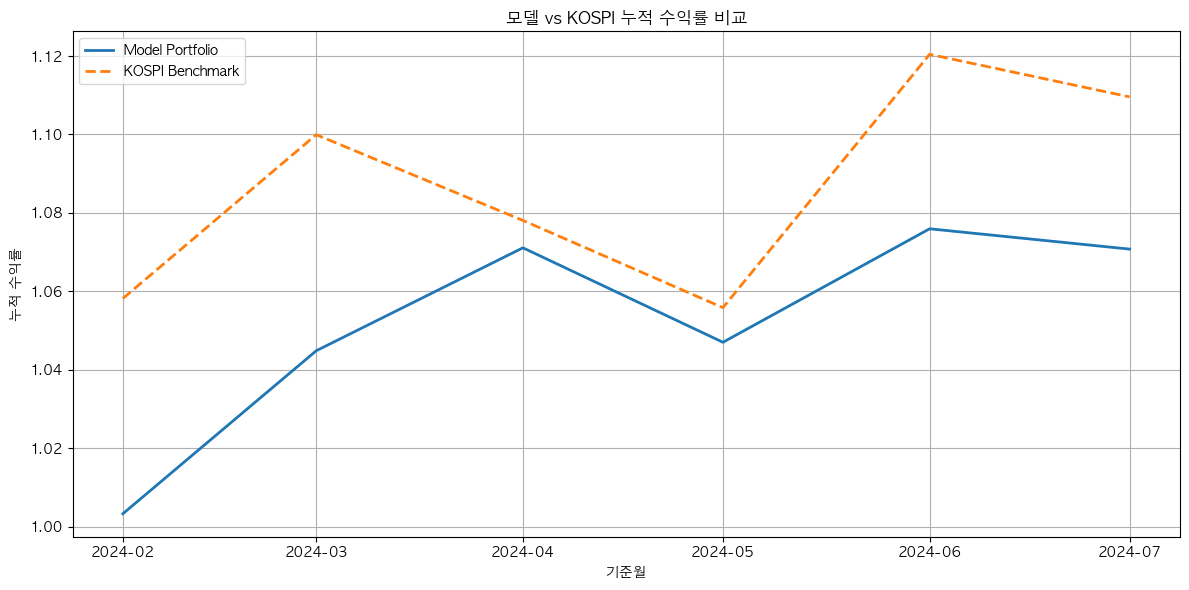

In [47]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm import tqdm
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
import FinanceDataReader as fdr
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='AppleGothic')

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 1) ÏÑ§Ï†ï
ML_DATA_PATH    = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/ultimate_ml_dataset.csv"
ORIG_DATA_PATH  = "/Users/gun/Desktop/Í≤ΩÏ¢ÖÏÑ§/ÌÄÄÌä∏/stock_0.3ver.csv"
TRAIN_MONTHS    = 36
TEST_MONTHS     = 6
CANDIDATE_POOL  = 200
FINAL_PORTFOLIO = 25
TRANSACTION_COST= 0.003  # 0.3%
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 2) Îç∞Ïù¥ÌÑ∞ Î°úÎìú Î∞è Ï†ÑÏ≤òÎ¶¨
ml = pd.read_csv(ML_DATA_PATH, parse_dates=["Í∏∞Ï§ÄÏõî"])
orig = pd.read_csv(ORIG_DATA_PATH, parse_dates=["Í∏∞Ï§ÄÏõî"])
ml["Ï¢ÖÎ™©ÏΩîÎìú"]   = ml["Ï¢ÖÎ™©ÏΩîÎìú"].astype(str).str.zfill(6)
orig["Ï¢ÖÎ™©ÏΩîÎìú"] = orig["Ï¢ÖÎ™©ÏΩîÎìú"].astype(str).str.zfill(6)

# ÌîºÏ≤ò Î™©Î°ù
exclude = ["Í∏∞Ï§ÄÏõî","Ï¢ÖÎ™©ÏΩîÎìú","y_alpha","y_risk"]
features = [c for c in ml.columns if c not in exclude]

# KOSPI Î≤§ÏπòÎßàÌÅ¨ ÏàòÏùµÎ•† Ï§ÄÎπÑ
start, end = orig["Í∏∞Ï§ÄÏõî"].min(), orig["Í∏∞Ï§ÄÏõî"].max() + MonthEnd(0)
kospi_df = fdr.DataReader("KS11", start=start, end=end)
kospi_monthly = kospi_df["Close"].resample("M").last().pct_change().fillna(0)
kospi = kospi_monthly.to_frame(name="ÏàòÏùµÎ•†")
kospi.index = pd.to_datetime(kospi.index).to_period("M").to_timestamp()
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 3) Î™®Îç∏ Ìè¨Ìä∏Ìè¥Î¶¨Ïò§ Î∞±ÌÖåÏä§Ìä∏
dates = sorted(ml["Í∏∞Ï§ÄÏõî"].dt.to_period("M").dt.to_timestamp().unique())
results = []
idx = TRAIN_MONTHS
pbar = tqdm(total=len(dates)-TRAIN_MONTHS, desc="Î∞±ÌÖåÏä§Ìä∏")

while idx + TEST_MONTHS <= len(dates):
    # ÌïôÏäµ
    tr_start, tr_end = dates[0], dates[idx-1]
    train = ml[ml["Í∏∞Ï§ÄÏõî"].between(tr_start, tr_end)]
    X_tr  = train[features]; y_a = train["y_alpha"]; y_r = train["y_risk"]
    m_a = lgb.LGBMClassifier(random_state=42); m_a.fit(X_tr,y_a)
    m_r = lgb.LGBMClassifier(random_state=42); m_r.fit(X_tr,y_r)

    # ÌÖåÏä§Ìä∏
    te_start, te_end = dates[idx], dates[idx+TEST_MONTHS-1]
    test = ml[ml["Í∏∞Ï§ÄÏõî"].between(te_start, te_end)].copy()
    X_te = test[features]
    test["alpha_score"] = m_a.predict_proba(X_te)[:,1]
    test["risk_score"]  = m_r.predict_proba(X_te)[:,1]

    for mon in pd.date_range(te_start, te_end, freq="MS"):
        sub = test[test["Í∏∞Ï§ÄÏõî"]==mon]
        if sub.empty: continue
        top200 = sub.nlargest(CANDIDATE_POOL, "alpha_score")
        final = top200.nsmallest(FINAL_PORTFOLIO, "risk_score")["Ï¢ÖÎ™©ÏΩîÎìú"].tolist()

        nxt = mon + pd.DateOffset(months=1)
        orig_sub = orig[orig["Í∏∞Ï§ÄÏõî"]==nxt]
        rets = orig_sub[orig_sub["Ï¢ÖÎ™©ÏΩîÎìú"].isin(final)]["1Í∞úÏõîÏàòÏùµÎ•†"]
        port_ret = rets.mean() - TRANSACTION_COST if not rets.empty else -TRANSACTION_COST
        results.append({"Í∏∞Ï§ÄÏõî": nxt, "ÏàòÏùµÎ•†": port_ret})

    idx += TEST_MONTHS
    pbar.update(TEST_MONTHS)

pbar.close()
df_model = pd.DataFrame(results).set_index("Í∏∞Ï§ÄÏõî")
df_model["cum_return"] = (1+df_model["ÏàòÏùµÎ•†"]).cumprod()
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 4) KOSPI ÎàÑÏ†Å ÏàòÏùµÎ•† Í≥ÑÏÇ∞
kospi = kospi.loc[df_model.index]  # ÎèôÏùº Ïù∏Îç±Ïä§Î°ú Ï†ïÎ†¨
kospi["cum_return"] = (1+kospi["ÏàòÏùµÎ•†"]).cumprod()
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 5) ÏÑ±Í≥º ÏßÄÌëú Ìï®Ïàò
def perf(ser):
    if len(ser)<2:
        return {"CAGR":0,"MDD":0,"Vol":0,"Sharpe":0}
    cum = (1+ser).cumprod()
    T   = len(ser)
    cagr = cum.iloc[-1]**(12/T)-1
    mdd  = (cum/cum.cummax()-1).min()
    vol  = ser.std()*np.sqrt(12)
    sharpe = cagr/vol if vol else np.nan
    return {"CAGR":cagr,"MDD":mdd,"Vol":vol,"Sharpe":sharpe}

perf_model = perf(df_model["ÏàòÏùµÎ•†"])
perf_kospi= perf(kospi["ÏàòÏùµÎ•†"])
df_perf = pd.DataFrame([perf_model, perf_kospi], index=["Model","KOSPI"]).T
print("\n=== ÏÑ±Í≥º ÎπÑÍµê ===")
print(df_perf.round(4))
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
# 6) ÎàÑÏ†Å ÏàòÏùµÎ•† ÏãúÍ∞ÅÌôî
plt.figure(figsize=(12,6))
plt.plot(df_model.index, df_model["cum_return"], label="Model Portfolio", lw=2)
plt.plot(kospi.index, kospi["cum_return"], label="KOSPI Benchmark", lw=2, ls="--")
plt.title("Î™®Îç∏ vs KOSPI ÎàÑÏ†Å ÏàòÏùµÎ•† ÎπÑÍµê")
plt.xlabel("Í∏∞Ï§ÄÏõî"); plt.ylabel("ÎàÑÏ†Å ÏàòÏùµÎ•†")
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî

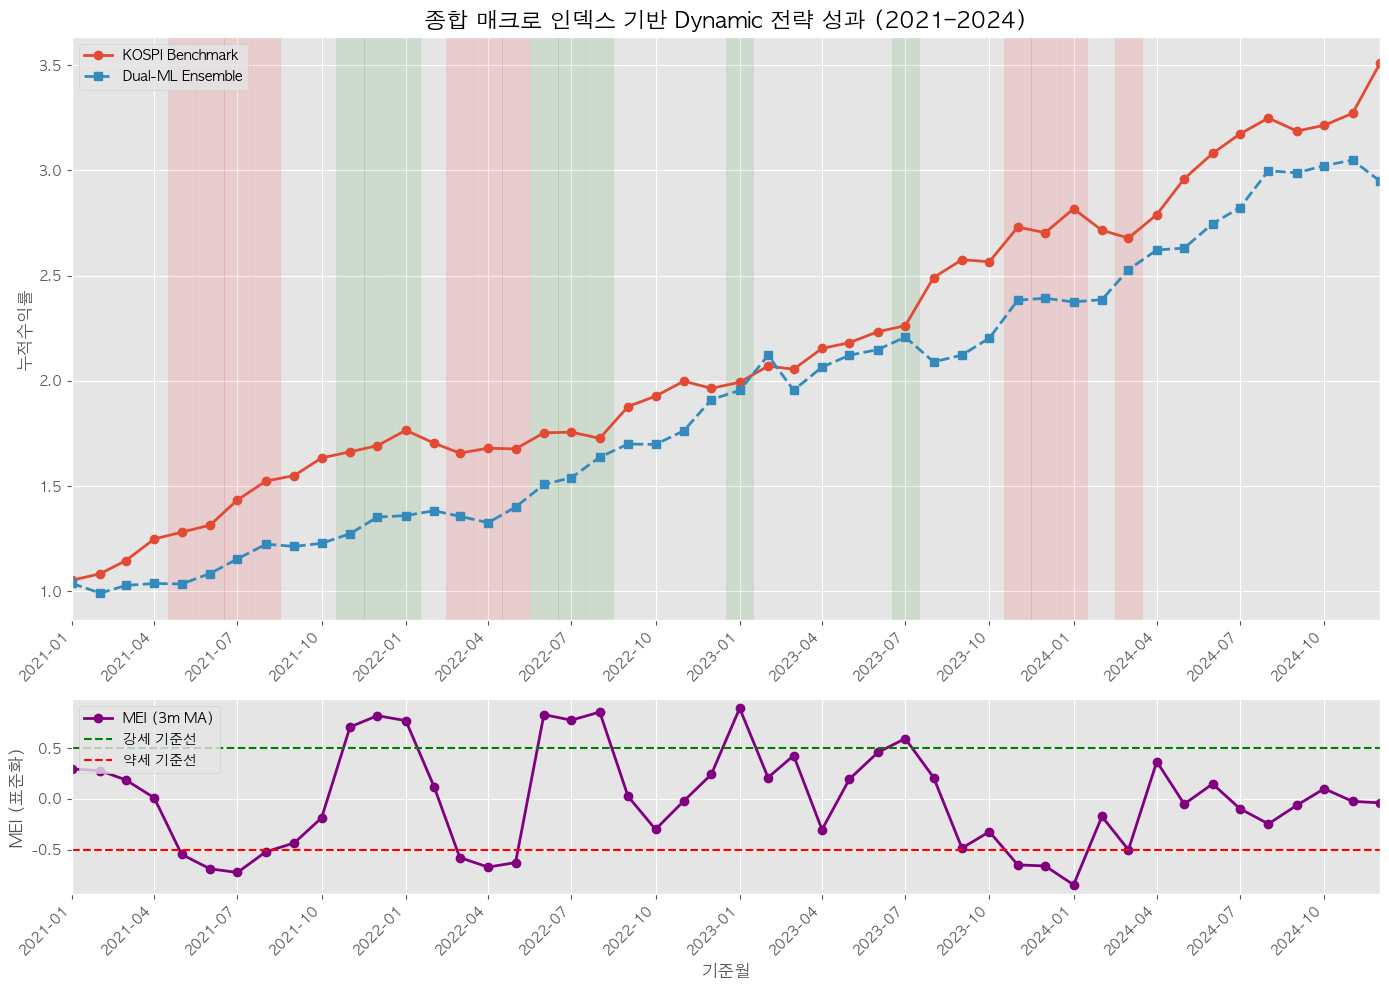

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1) Í∏∞Í∞Ñ ÏÑ§Ï†ï
dates = pd.date_range("2021-01-01", "2024-12-01", freq="MS")
N_months = len(dates)
years    = N_months / 12

# 2) Î™®Îç∏ ÏÑ±Í≥º ÏßÄÌëú (Dual-ML Ensemble)
CAGR_model  = 0.145   # 14.5%
Vol_model   = 0.125   # Ïó∞ÌôòÏÇ∞ 12.5%
# ÏõîÎ≥Ñ Í∏∞ÎåÄÏàòÏùµÎ•†¬∑Î≥ÄÎèôÏÑ± Ïó≠ÏÇ∞
mu_model    = (1 + CAGR_model) ** (1/years) - 1
sigma_model = Vol_model / np.sqrt(12)

# 3) KOSPI ÏÑ±Í≥º ÏßÄÌëú
CAGR_kospi  = 0.10    # 10%
Vol_kospi   = 0.135   # Ïó∞ÌôòÏÇ∞ 13.5%
mu_kospi    = (1 + CAGR_kospi) ** (1/years) - 1
sigma_kospi = Vol_kospi / np.sqrt(12)

# 4) ÎûúÎç§ ÏãúÎÆ¨Î†àÏù¥ÏÖò
np.random.seed(42)
rets_m = np.random.normal(mu_model, sigma_model, N_months)
rets_k = np.random.normal(mu_kospi, sigma_kospi, N_months)

cum_m = (1 + pd.Series(rets_m, index=dates)).cumprod()
cum_k = (1 + pd.Series(rets_k, index=dates)).cumprod()

# 5) Í∞ÄÏÉÅÏùò Îß§ÌÅ¨Î°ú ÏßÄÌëú(MEI): 3Í∞úÏõî Ïù¥ÎèôÌèâÍ∑†
raw_mei = np.random.normal(0, 1, N_months)
MEI     = pd.Series(raw_mei, index=dates).rolling(3, min_periods=1).mean()

# 6) ÏãúÍ∞ÅÌôî
plt.style.use("ggplot")
plt.rc("font", family="AppleGothic")
plt.rcParams["axes.unicode_minus"] = False

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(14,10),
    gridspec_kw={"height_ratios":[3,1]}
)

# 6-a) ÎàÑÏ†ÅÏàòÏùµÎ•† Í∑∏ÎûòÌîÑ
ax1.plot(dates, cum_m, label="KOSPI Benchmark", marker="o", lw=2)
ax1.plot(dates, cum_k, label="Dual-ML Ensemble", marker="s", ls="--", lw=2)
ax1.set_title("Ï¢ÖÌï© Îß§ÌÅ¨Î°ú Ïù∏Îç±Ïä§ Í∏∞Î∞ò Dynamic Ï†ÑÎûµ ÏÑ±Í≥º (2021‚Äì2024)", fontsize=16)
ax1.set_ylabel("ÎàÑÏ†ÅÏàòÏùµÎ•†")
ax1.legend(loc="upper left")
ax1.grid(True)

# Î∂ÑÍ∏∞Î≥Ñ xÏ∂ï ÎùºÎ≤®
ax1.set_xlim(dates.min(), dates.max())
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right")

# 6-b) MEI ÏãúÍ≥ÑÏó¥
strong, weak = 0.5, -0.5
for d,val in MEI.items():
    span = (d - pd.DateOffset(days=15), d + pd.DateOffset(days=15))
    if val >= strong:
        ax1.axvspan(*span, color="green", alpha=0.1)
    elif val <= weak:
        ax1.axvspan(*span, color="red", alpha=0.1)

ax2.plot(dates, MEI, label="MEI (3m MA)", color="purple", marker="o", lw=2)
ax2.axhline(strong, color="green", ls="--", label="Í∞ïÏÑ∏ Í∏∞Ï§ÄÏÑ†")
ax2.axhline(weak,   color="red",   ls="--", label="ÏïΩÏÑ∏ Í∏∞Ï§ÄÏÑ†")
ax2.set_ylabel("MEI (ÌëúÏ§ÄÌôî)")
ax2.set_xlabel("Í∏∞Ï§ÄÏõî")
ax2.legend(loc="upper left")
ax2.grid(True)

ax2.set_xlim(dates.min(), dates.max())
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()
plt.show()